# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
# --- Extension Setup ---
%load_ext autoreload
%load_ext line_profiler
%autoreload 3 -p

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Autoreload Target ---
%aimport afml

# --- AFML Initialization ---
import afml

# Check if auto-reload is available
print(f"Auto-reload available: {afml.AUTO_RELOAD_AVAILABLE}")

# Setup with auto-reload enabled
app = afml.setup_jupyter(enable_auto_reload=True)

# # --- Logging (Optional but Recommended) ---
# from loguru import logger
# from pathlib import Path

# # Optional: clear old logs
# log_path = Path("logs") / "afml_session.log"
# log_path.parent.mkdir(exist_ok=True)
# log_path.unlink(missing_ok=True)

# # Configure Loguru
# logger.add(log_path, level="INFO", rotation="10 MB", retention="10 days")
# logger.info("Session started")

# --- Environment Diagnostics ---
from pathlib import Path
print(f"Working Dir: {Path.cwd()}")


2025-10-14 05:39:46.135 | DEBUG    | afml.cache:<module>:344 - Auto-reload functionality available
2025-10-14 05:39:46.137 | DEBUG    | afml.cache:_configure_numba:61 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-10-14 05:39:46.138 | INFO     | afml.cache:initialize_cache_system:310 - AFML cache system initialized:
2025-10-14 05:39:46.139 | INFO     | afml.cache:initialize_cache_system:311 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-10-14 05:39:46.148 | INFO     | afml.cache:initialize_cache_system:312 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-10-14 05:39:46.151 | INFO     | afml.cache:initialize_cache_system:318 -   Loaded stats: 4 functions, 37.8% hit rate
2025-10-14 05:39:52.569 | DEBUG    | afml.cache.selective_cleaner:_load_tracking_data:39 - Loaded tracking data for 17 functions
2025-10-14 05:39:59.089 | DEBUG    | afml:<module>:91 - Imported lightweight modules direct

Auto-reload available: True
Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [2]:
import warnings
import winsound
from datetime import datetime as dt
from datetime import timedelta
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import talib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score, recall_score
from sklearn.base import clone

from afml.backtest_statistics import calculate_performance_metrics
from afml.backtester import (
    compare_pr_curves,
    compare_roc_curves,
    compare_roc_pr_curves,
    get_optimal_threshold,
    labeling_reports,
    meta_labeling_classification_report_images,
    meta_labeling_classification_report_tables,
    meta_labeling_reports,
    run_meta_labeling_analysis,
    train_model,
    train_model_with_trend,
)
from afml.bet_sizing.bet_sizing import (
    bet_size_budget,
    bet_size_probability,
    bet_size_reserve,
)
from afml.cache import cache_maintenance, clear_afml_cache, selective_cache_clear
from afml.cross_validation.cross_validation import (
    PurgedKFold,
    PurgedSplit,
    ml_cross_val_score,
    ml_cross_val_scores_all,
)
from afml.cross_validation.scoring import probability_weighted_accuracy
from afml.data_structures.bars import *
from afml.features import get_fractal_features, get_time_features, is_stationary
from afml.filters import cusum_filter
from afml.labeling import (
    add_vertical_barrier,
    drop_labels,
    get_event_weights,
    get_events,
    trend_scanning_labels,
    triple_barrier_labels,
)
from afml.mt5.load_data import (
    clean_tick_data,
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
)
from afml.sample_weights.optimized_attribution import (
    get_weights_by_time_decay_optimized,
)
from afml.sampling import (
    SequentiallyBootstrappedBaggingClassifier,
    get_ind_mat_average_uniqueness,
    get_ind_matrix,
    seq_bootstrap,
)
from afml.strategies import (
    BollingerStrategy,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
    plot_bbands,
    plot_bbands_dual_bbp_bw,
)
from afml.util import (
    CLEAN_DATA_PATH,
    COMMODITIES,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    GREEKS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    get_period_vol,
    smart_subscript,
    to_subscript,
    value_counts_data,
)

warnings.filterwarnings("ignore")
plt.style.use("dark_background")

In [3]:
# clear_afml_cache()
pprint(cache_maintenance(), sort_dicts=False)

2025-10-14 05:40:05 | INFO     | No function changes detected
2025-10-14 05:40:05 | INFO     | Cache maintenance completed: 10 functions checked
{'functions_checked': 10,
 'changed_functions': [],
 'cleared_functions': [],
 'size_cleared_mb': 0,
 'old_files_removed': 0}


## 1. Data Preparation

In [4]:
account = "FundedNext_STLR2_6K"
# account = "METAQUOTES_DEMO_25K"
# account = login_mt5(account)
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2021-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date

In [5]:
def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict.get(timeframe)
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
            print(f"Loading ticks from {CLEAN_DATA_PATH}...")
        except FileNotFoundError:
            print(f"Downloading ticks to {DATA_PATH}...")
            save_data_to_parquet(DATA_PATH, symbol, start_date, end_date, account)
            tick_df = load_tick_data(DATA_PATH, symbol, start_date, end_date, account, columns)
            tick_df = clean_tick_data(tick_df)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

## 2. Bollinger Band Strategy

In [6]:
bb_timeframe = "M5"
tick_bar_size = tick_bar_dict.get(bb_timeframe)
print(f"{bb_timeframe} = tick-{tick_bar_size}")
bb_time_bars, bb_tick_bars = get_data(symbol, bb_timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"

M5 = tick-200
Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


In [7]:
bb_period, bb_std = 20, 1.5 # Bollinger Band parameters
bb_strategy = BollingerStrategy(window=bb_period, num_std=bb_std)
bb_lookback = 10
bb_pt_barrier, bb_sl_barrier, bb_time_horizon = (1, 2, 50)
min_ret = 0.0
bb_vol_multiplier = 1
linear_decay = False

#### Volatility Charts

In [8]:
start = "2018-01-01 06:00"
end = "2018-02-01 06:00"
plot_timeframe = "M5"
df_time_bars, df_tick_bars = get_data(symbol, plot_timeframe)
vol_lookback0 = 100

Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


2025-10-14 05:40:15 | INFO     | 12,702 CUSUM-filtered events
2025-10-14 05:40:16 | INFO     | Bollinger_w20_std1.5 | 10,692 (6.35%) trade events selected by CUSUM filter (threshold = 0.1859%).


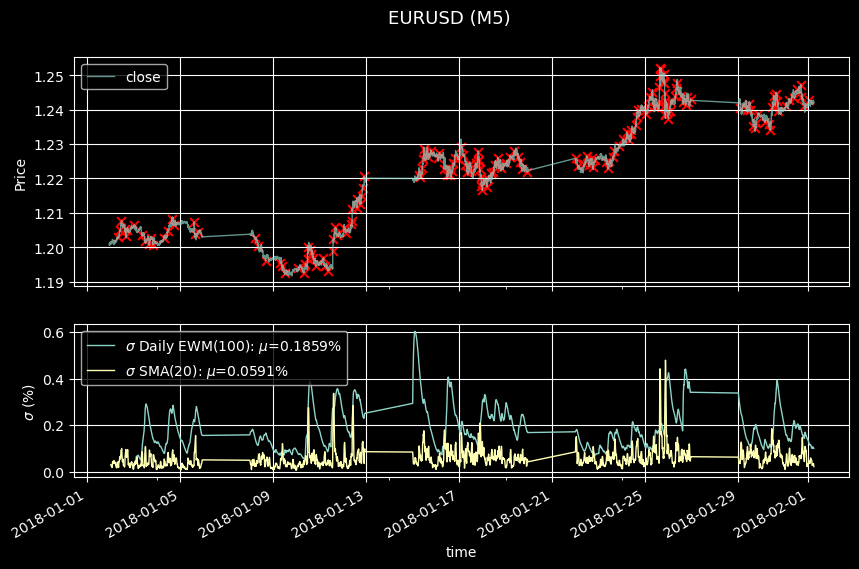

In [9]:
close_time = df_time_bars.close.loc[start:end]
target_time = get_daily_vol(close_time, vol_lookback0).reindex(close_time.index)
target_time_bb = close_time.rolling(bb_period).std()
side, t_events_time = get_entries(bb_strategy, df_time_bars, filter_threshold=target_time.mean())

fig, ax = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[3,2], sharex=True)

close_time.plot(ax=ax[0], legend=True, ylabel="Price", linewidth=1, grid=True, alpha=0.7)
ax[0].scatter(t_events_time, close_time.reindex(t_events_time), marker='x', color='red', s=40)
(target_time * 100).plot(ax=ax[1], legend=True, ylabel=r"$\sigma$ (%)", label=fr"$\sigma$ Daily EWM({vol_lookback0}): $\mu$={target_time.mean():.4%}", linewidth=1, grid=True)
(target_time_bb * 100).plot(ax=ax[1], legend=True, ylabel=r"$\sigma$ (%)", label=fr"$\sigma$ SMA({bb_period}): $\mu$={target_time_bb.mean():.4%}", linewidth=1, grid=True)

fig.suptitle(f"{symbol} ({plot_timeframe})", fontsize=13)
fig.subplots_adjust(top=0.9)

2025-10-14 05:40:21 | INFO     | 32,422 CUSUM-filtered events
2025-10-14 05:40:21 | INFO     | Bollinger_w20_std1.5 | 27,861 (10.35%) trade events selected by CUSUM filter (threshold = 0.1217%).


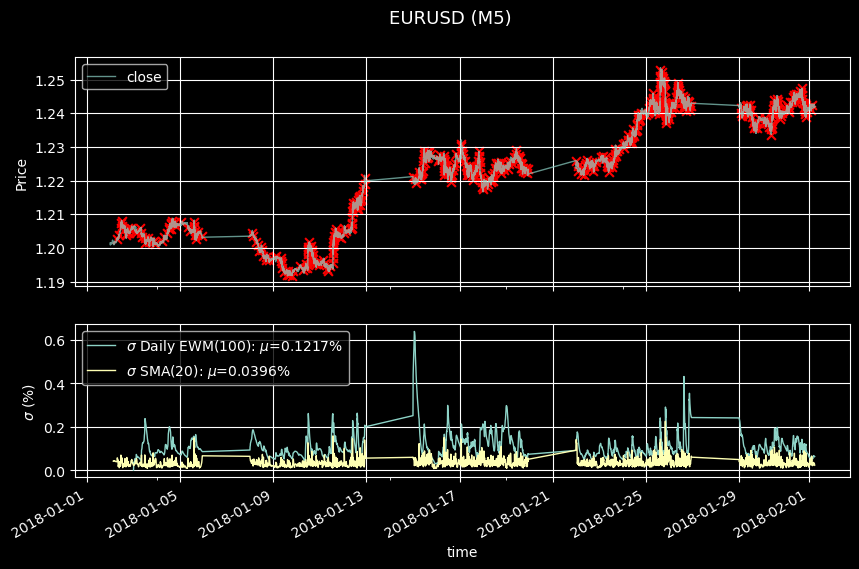

In [10]:
close_tick = df_tick_bars.close.loc[start:end]
target_tick = get_daily_vol(close_tick, vol_lookback0).reindex(close_tick.index)
target_tick_bb = close_tick.rolling(bb_period).std()
side, t_events_tick = get_entries(bb_strategy, df_tick_bars, filter_threshold=target_tick.mean())

fig, ax = plt.subplots(2, 1, figsize=(10, 6), height_ratios=[3,2], sharex=True)

close_tick.plot(ax=ax[0], legend=True, ylabel="Price", linewidth=1, grid=True, alpha=0.7)
ax[0].scatter(t_events_tick, close_tick.reindex(t_events_tick), marker='x', color='red', s=40)
(target_tick * 100).plot(ax=ax[1], legend=True, ylabel=r"$\sigma$ (%)", label=fr"$\sigma$ Daily EWM({vol_lookback0}): $\mu$={target_tick.mean():.4%}", linewidth=1, grid=True)
(target_tick_bb * 100).plot(ax=ax[1], legend=True, ylabel=r"$\sigma$ (%)", label=fr"$\sigma$ SMA({bb_period}): $\mu$={target_tick_bb.mean():.4%}", linewidth=1, grid=True)

fig.suptitle(f"{symbol} ({plot_timeframe})", fontsize=13)
fig.subplots_adjust(top=0.9)

### Time-Bars

In [11]:
bb_side = bb_strategy.generate_signals(bb_time_bars)
bb_df = bb_time_bars #.loc[sample_start : sample_end]

print(f"{bb_strategy.get_strategy_name()} Signals:")
value_counts_data(bb_side.reindex(bb_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = 100
vol_target = get_daily_vol(bb_df.close, vol_lookback) * bb_vol_multiplier
close = bb_df.close
_, t_events = get_entries(bb_strategy, bb_df, filter_threshold=vol_target)

vertical_barriers = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)

Bollinger_w20_std1.5 Signals:

        count  proportion
side                     
 0    348,785    0.674481
-1     84,888    0.164157
 1     83,443    0.161362

2025-10-14 05:40:27 | INFO     | 22,667 CUSUM-filtered events
2025-10-14 05:40:27 | INFO     | Bollinger_w20_std1.5 | 17,346 (10.30%) trade events selected by CUSUM filter using series.


#### Feature Engineering

In [12]:
bb_feat = create_bollinger_features(bb_time_bars, bb_period, bb_std)
bb_feat_time = bb_feat.copy()
bb_feat_time.info()
# not_stationary = is_stationary(bb_feat_time)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 516825 entries, 2018-01-02 23:20:00 to 2024-12-31 00:00:00
Data columns (total 47 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   close                516825 non-null  float32
 1   spread               516825 non-null  float32
 2   vol                  516825 non-null  float32
 3   h1_vol               516825 non-null  float32
 4   h4_vol               516825 non-null  float32
 5   d1_vol               516825 non-null  float32
 6   ret                  516825 non-null  float32
 7   ret_5                516825 non-null  float32
 8   ret_10               516825 non-null  float32
 9   ret_1_lag_1          516825 non-null  float32
 10  ret_5_lag_1          516825 non-null  float32
 11  ret_10_lag_1         516825 non-null  float32
 12  ret_1_lag_2          516825 non-null  float32
 13  ret_5_lag_2          516825 non-null  float32
 14  ret_10_lag_2         516825 non-nu

#### Triple-Barrier Method

In [13]:
bb_events_tb = triple_barrier_labels(
    close,
    vol_target,
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tb = get_event_weights(bb_events_tb, close)
bb_events_tb_time = bb_events_tb.copy()

print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb.bin, verbose=True)

av_uniqueness = bb_events_tb['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h=50):

     count  proportion
bin                   
0    9,757    0.562525
1    7,588    0.437475

Average Uniqueness: 0.6687


In [14]:
bb_events_tb = triple_barrier_labels(
    close,
    close.rolling(bb_period).std(),
    t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=min_ret,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tb = get_event_weights(bb_events_tb, close)
bb_events_tb_time1 = bb_events_tb.copy()

print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon}):")
value_counts_data(bb_events_tb.bin, verbose=True)

av_uniqueness1 = bb_events_tb['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness1:.4f}")

Triple-Barrier (pt=1, sl=2, h=50):

      count  proportion
bin                    
1    10,825    0.624099
0     6,520    0.375901

Average Uniqueness: 0.9244


SR Daily EWM(100): 0.0258
SR SMA_20: 0.0177


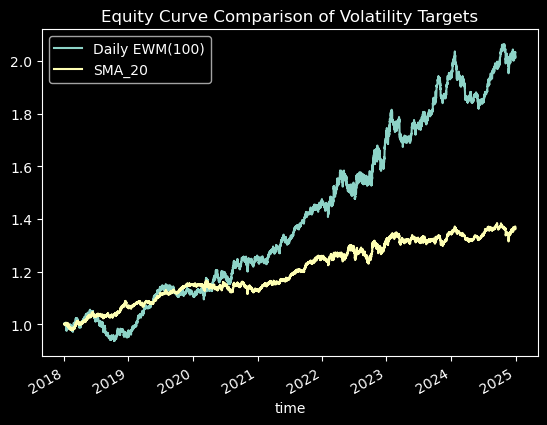

In [15]:
(1 + bb_events_tb_time.ret).cumprod().plot(label=f"Daily EWM({vol_lookback})")
(1 + bb_events_tb_time1.ret).cumprod().plot(label=f"SMA_{bb_period}")
plt.title("Equity Curve Comparison of Volatility Targets")
plt.legend();

print(f"SR Daily EWM({vol_lookback}): {bb_events_tb_time.ret.mean() / bb_events_tb_time.ret.std():.4f}")
print(f"SR SMA_{bb_period}: {bb_events_tb_time1.ret.mean() / bb_events_tb_time1.ret.std():.4f}")

In [16]:
dashes = "-" * 60

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

random_state = 10
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Strategy: Bollinger_w20_std1.5


#### Cross-Validation of Weighting Methods

In [17]:
random_state = 42
min_w_leaf = 0.05

clf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

In [18]:
cont = bb_events_tb_time.copy()
X = bb_feat_time.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.25
n_splits = 3
pct_embargo = 0.01

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )

In [19]:
decay_factors = [0.05, 0.25, 0.5, 0.75, 1]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    decay=time_decay,
                    linear=linear,
                    av_uniqueness=cont["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        # time_decay_weights[f"{method}_time_decay_{time_decay}_uniqueness"] = decay_w * cont["tW"]
        # time_decay_weights[f"{method}_time_decay_{time_decay}_return_attribution"] = decay_w * cont["w"]
    
weighting_schemes = {
    "none": pd.Series(1., index=cont.iloc[train].index),
    "uniqueness": cont["tW"].iloc[train],
    "return-attribution": cont["w"].iloc[train],
    }

for k, v in time_decay_weights.items():
    weighting_schemes[k] = v.iloc[train]
    # if k.startswith('exp'):
    #     weighting_schemes[k.replace('exp_', '')] = v.iloc[train]

weighting_schemes.keys()

dict_keys(['none', 'uniqueness', 'return-attribution', 'linear_time_decay_0.05', 'exp_time_decay_0.05', 'linear_time_decay_0.25', 'exp_time_decay_0.25', 'linear_time_decay_0.5', 'exp_time_decay_0.5', 'linear_time_decay_0.75', 'exp_time_decay_0.75', 'linear_time_decay_1', 'exp_time_decay_1'])

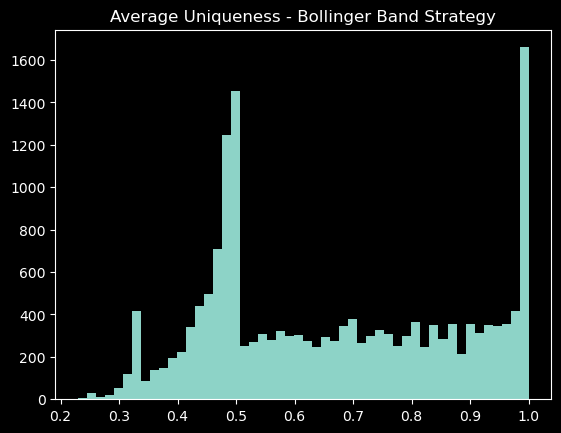

In [20]:
plt.hist(cont["tW"], bins=50)
plt.title("Average Uniqueness - Bollinger Band Strategy");

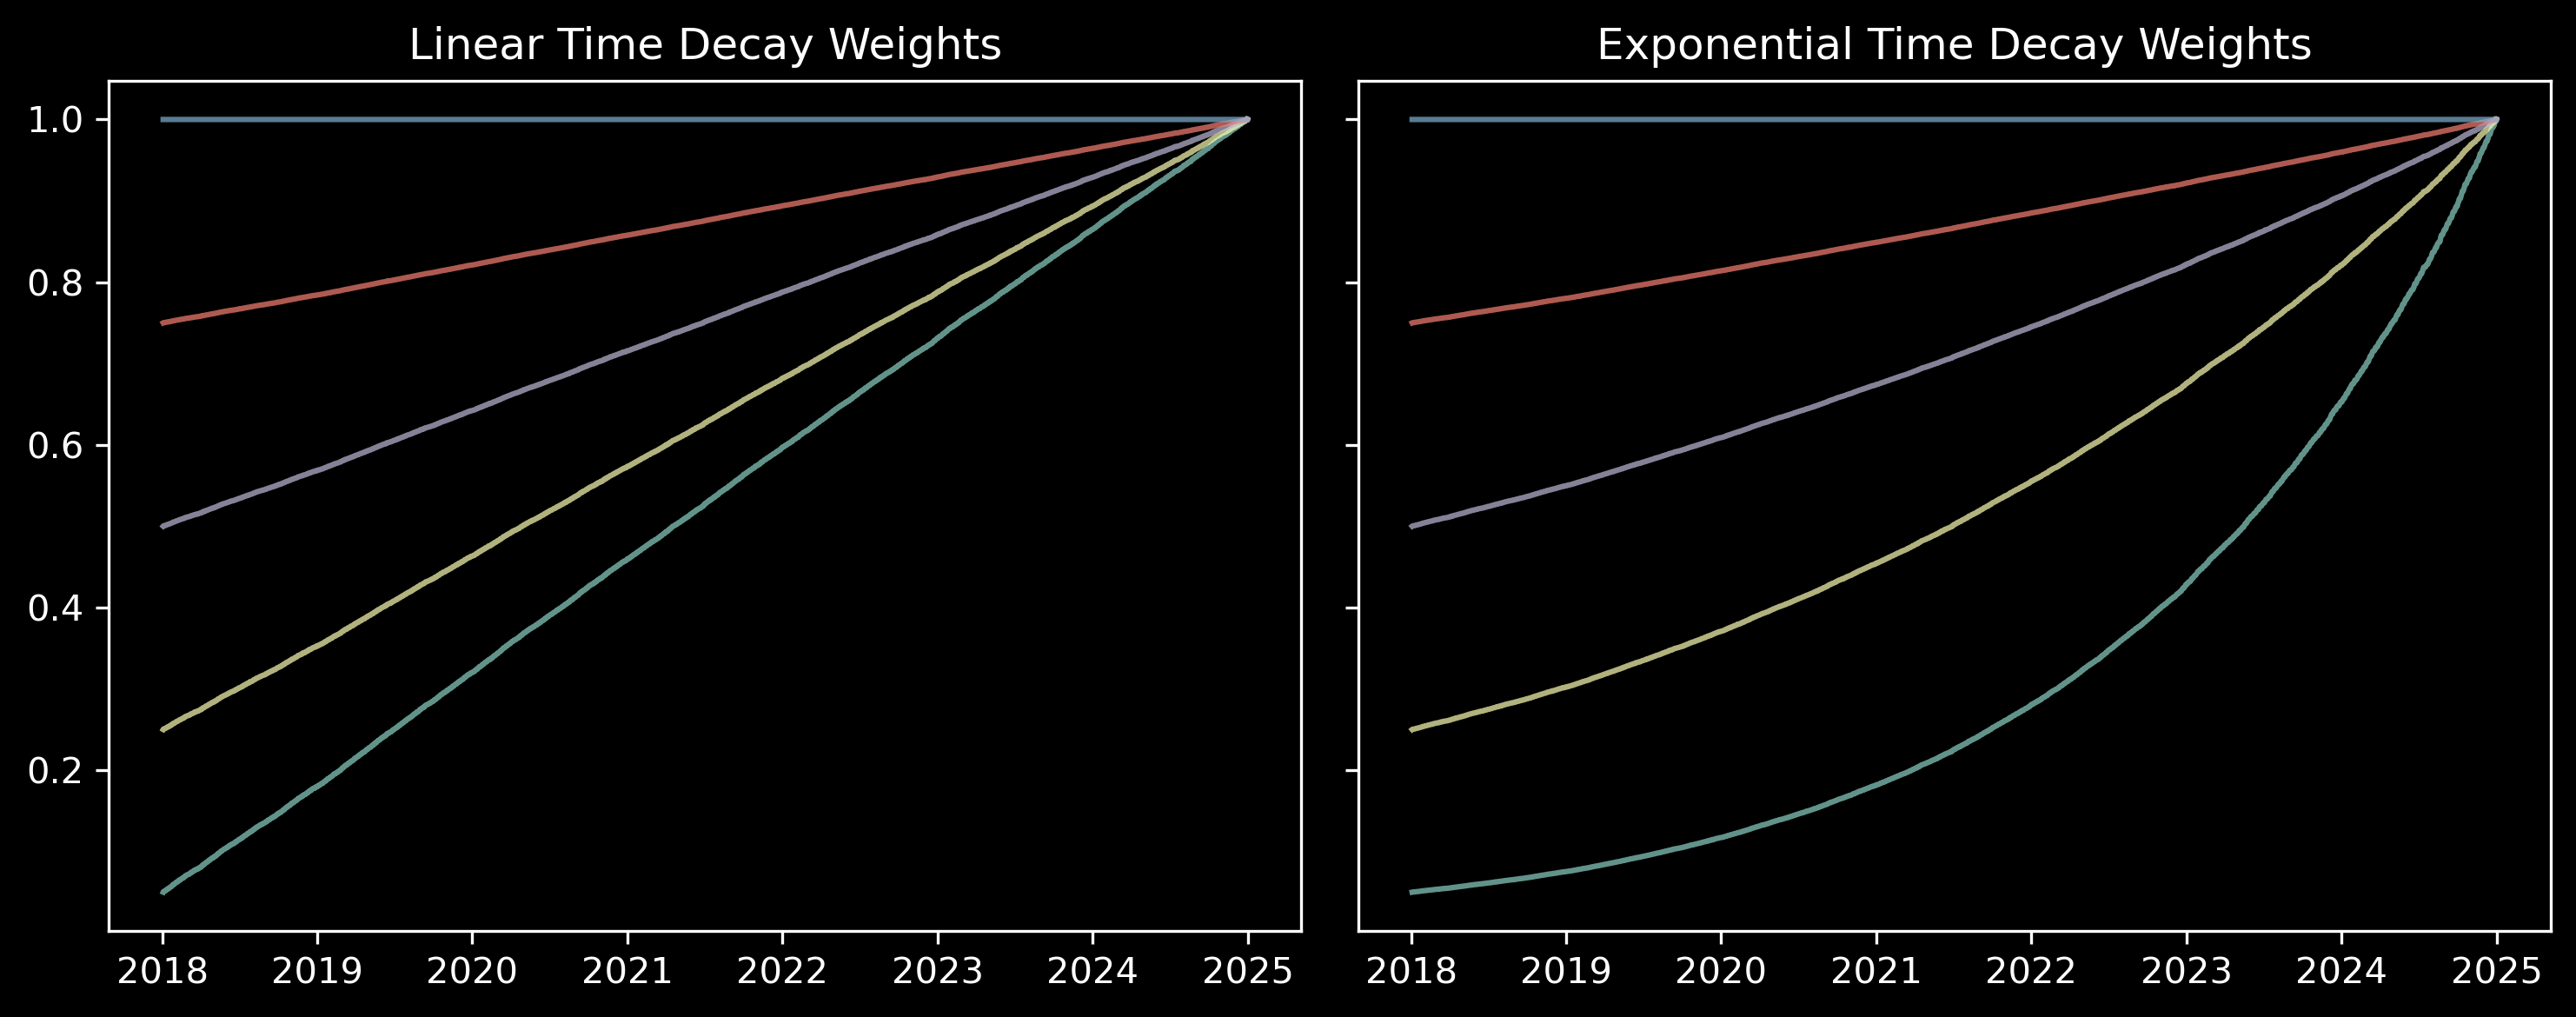

In [21]:
linear_plt, exp_plt = [], []
for decay, decay_w in time_decay_weights.items():
    if decay.startswith('linear'):
        linear_plt.append(decay_w)
    else:
        exp_plt.append(decay_w)
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, dpi=300)
for w in linear_plt:
    ax[0].plot(w, alpha=0.7)
ax[0].set_title('Linear Time Decay Weights')
for w in exp_plt:
    ax[1].plot(w, alpha=0.7)
ax[1].set_title('Exponential Time Decay Weights')
plt.tight_layout();

fig.savefig("time_decay_weights.png", dpi=300)


In [22]:
decay_factors = [0.25, 0.5, 0.75]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    decay=time_decay,
                    linear=linear,
                    av_uniqueness=cont["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        # time_decay_weights[f"{method}_time_decay_{time_decay}_uniqueness"] = decay_w * cont["tW"]
        # time_decay_weights[f"{method}_time_decay_{time_decay}_return_attribution"] = decay_w * cont["w"]
    
weighting_schemes = {
    "none": pd.Series(1., index=cont.iloc[train].index),
    "uniqueness": cont["tW"].iloc[train],
    "return-attribution": cont["w"].iloc[train],
    }

for k, v in time_decay_weights.items():
    weighting_schemes[k] = v.iloc[train]
    # if k.startswith('exp'):
    #     weighting_schemes[k.replace('exp_', '')] = v.iloc[train]

weighting_schemes.keys()

dict_keys(['none', 'uniqueness', 'return-attribution', 'linear_time_decay_0.25', 'exp_time_decay_0.25', 'linear_time_decay_0.5', 'exp_time_decay_0.5', 'linear_time_decay_0.75', 'exp_time_decay_0.75'])

In [23]:
cv_gen = PurgedKFold(n_splits, t1.iloc[train], pct_embargo)
cv_scores_d = {}
print(clf.__class__.__name__, "Weighting Schemes")

for scheme, sample_weights in weighting_schemes.items():
    print(f"\n{scheme}:")
    w = sample_weights.values
    cv_scores = ml_cross_val_scores_all(
        clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    cv_scores_d[scheme] = cv_scores
    for scoring, cv_score in cv_scores.items():
        print(f"  {scoring}: μ = {cv_score.mean():.6f}, σ = {cv_score.std():.6f}")


RandomForestClassifier Weighting Schemes

none:
  accuracy_score: μ = 0.556128, σ = 0.004888
  probability_weighted_accuracy: μ = 0.572984, σ = 0.004841
  neg_log_loss: μ = -0.687394, σ = 0.000455
  f1_score: μ = 0.495779, σ = 0.066743

uniqueness:
  accuracy_score: μ = 0.583030, σ = 0.007497
  probability_weighted_accuracy: μ = 0.620698, σ = 0.010663
  neg_log_loss: μ = -0.678795, σ = 0.001252
  f1_score: μ = 0.426745, σ = 0.064602

return-attribution:
  accuracy_score: μ = 0.686414, σ = 0.012803
  probability_weighted_accuracy: μ = 0.686574, σ = 0.013709
  neg_log_loss: μ = -0.630171, σ = 0.006923
  f1_score: μ = 0.000000, σ = 0.000000

linear_time_decay_0.25:
  accuracy_score: μ = 0.554407, σ = 0.008369
  probability_weighted_accuracy: μ = 0.570967, σ = 0.006545
  neg_log_loss: μ = -0.687713, σ = 0.000785
  f1_score: μ = 0.508140, σ = 0.054810

exp_time_decay_0.25:
  accuracy_score: μ = 0.554318, σ = 0.007114
  probability_weighted_accuracy: μ = 0.572339, σ = 0.006178
  neg_log_loss

In [24]:
cv_scores_mu_df = pd.DataFrame(index=cv_scores_d.keys()) 
cv_scores_std_df = pd.DataFrame(index=cv_scores_d.keys()) 


for idx, dict_ in cv_scores_d.items():
    for key, val in dict_.items():
        col = key.replace('_score', '').replace('probability_weighted_accuracy', 'PWA')
        cv_scores_mu_df.loc[idx, col] = val.mean()
        cv_scores_std_df.loc[idx, col] = val.std()

print(f"Mean of CV Scores: \n{cv_scores_mu_df}")
print(f"\nStd of CV Scores: \n{cv_scores_std_df}")        

Mean of CV Scores: 
                        accuracy       PWA  neg_log_loss        f1
none                    0.556128  0.572984     -0.687394  0.495779
uniqueness              0.583030  0.620698     -0.678795  0.426745
return-attribution      0.686414  0.686574     -0.630171  0.000000
linear_time_decay_0.25  0.554407  0.570967     -0.687713  0.508140
exp_time_decay_0.25     0.554318  0.572339     -0.687605  0.507833
linear_time_decay_0.5   0.556965  0.571880     -0.687587  0.507457
exp_time_decay_0.5      0.556876  0.571737     -0.687610  0.506592
linear_time_decay_0.75  0.556631  0.573288     -0.687431  0.499142
exp_time_decay_0.75     0.554554  0.573279     -0.687422  0.496280

Std of CV Scores: 
                        accuracy       PWA  neg_log_loss        f1
none                    0.004888  0.004841      0.000455  0.066743
uniqueness              0.007497  0.010663      0.001252  0.064602
return-attribution      0.012803  0.013709      0.006923  0.000000
linear_time_decay_0.25

#### Sequentially Bootstrapping Bagging Classifiers

In [ ]:
train_ = train[:1000]

base_rf = RandomForestClassifier(
    n_estimators=1, 
    criterion="entropy", 
    class_weight="balanced_subsample", 
    bootstrap=False, 
    min_weight_fraction_leaf=0.05
    )
seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=t1[train],
    price_bars_index=close.index,
    estimator=base_rf,
    random_state=42,
    # max_samples=cont['tW'][train].mean(),
    oob_score=True,
    n_jobs=-1,
    verbose=True,
)

seq_fit = seq_rf.fit(X.iloc[train], y[train], sample_weight=cont["w"][train])
seq_probs = seq_rf.predict_proba(X.iloc[test])
seq_pred = seq_rf.predict(X.iloc[test])
print(f"OOB Score: {seq_rf.oob_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y.iloc[test], seq_pred):.4f}")
print(f"Test F1 Score: {f1_score(y.iloc[test], seq_pred):.4f}")
print(f"Test Log Loss: {log_loss(y.iloc[test], seq_probs):.4f}")
print(f"Test Precision: {precision_score(y.iloc[test], seq_pred):.4f}")
print(f"Test Recall: {recall_score(y.iloc[test], seq_pred):.4f}")

# cv_scores_seq = {}
# cv_gen = PurgedKFold(n_splits, cont['t1'].iloc[train], pct_embargo=0.01)

# print("SequentiallyBootstrappedBaggingClassifier")
# for i, (scheme, sample_weights) in enumerate(weighting_schemes.items()):
#     if i >= 3:
#          break
    
#     print(f"\n{scheme}:")
#     w = sample_weights.values
#     cv_scores = ml_cross_val_scores_all(
#         seq_rf, X_train, y_train, cv_gen, 
#         sample_weight_train=w, 
#         sample_weight_score=w, 
#     )
#     cv_scores_seq[scheme] = cv_scores
#     for scoring, cv_score in cv_scores_seq.items():
#         print(f"  {scoring}: μ = {cv_score.mean():.6f}, σ = {cv_score.std():.6f}")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


#### Random Forest

In [ ]:
random_state = 1
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

##### Unweighted

2025-10-12 00:46:20 | INFO     | Samples are equally weighted.
2025-10-12 00:46:20 | INFO     | Average uniqueness: 0.6666
2025-10-12 00:46:20 | INFO     | Training on 12,142 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2938
           1       0.44      1.00      0.61      2265

    accuracy                           0.44      5203
   macro avg       0.22      0.50      0.30      5203
weighted avg       0.19      0.44      0.26      5203


Confusion Matrix:
[[   0 2938]
 [   0 2265]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      2938
           1    

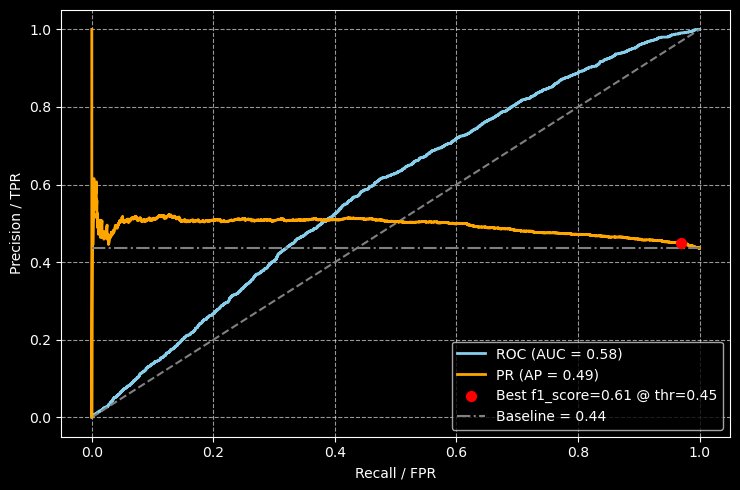

In [ ]:
model_bb_tb_time = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tb_time, plot=True)

2025-10-12 00:46:57 | INFO     | Samples are equally weighted.
2025-10-12 00:46:57 | INFO     | Average uniqueness: 0.9214
2025-10-12 00:46:57 | INFO     | Training on 12,142 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1971
           1       0.62      1.00      0.77      3232

    accuracy                           0.62      5203
   macro avg       0.31      0.50      0.38      5203
weighted avg       0.39      0.62      0.48      5203


Confusion Matrix:
[[   0 1971]
 [   0 3232]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.41      0.32      0.36      1971
           1    

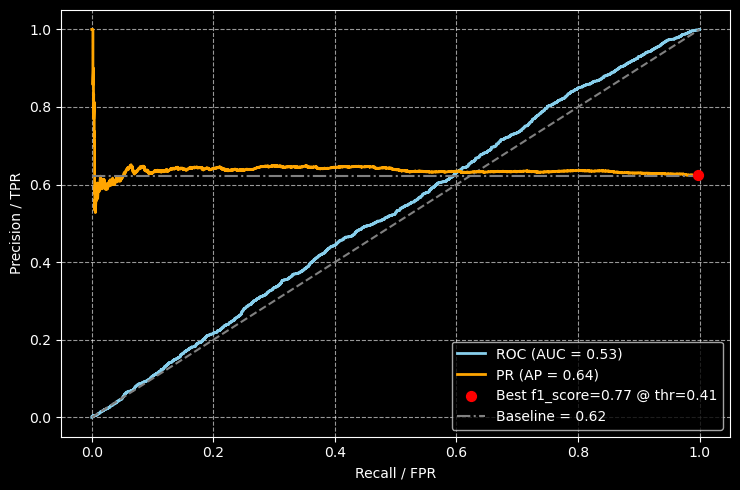

In [ ]:
model_bb_tb_time1 = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time1)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tb_time1, plot=True)

##### Return-Weighted

Reloading 'afml.backtester.training'.
2025-10-11 21:17:37 | INFO     | Samples weighted by uniqueness.
2025-10-11 21:17:37 | INFO     | Training on 5,478 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1453
           1       0.38      1.00      0.55       894

    accuracy                           0.38      2347
   macro avg       0.19      0.50      0.28      2347
weighted avg       0.15      0.38      0.21      2347


Confusion Matrix:
[[   0 1453]
 [   0  894]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.45      0.56      1453
           1       0.45      0.72    

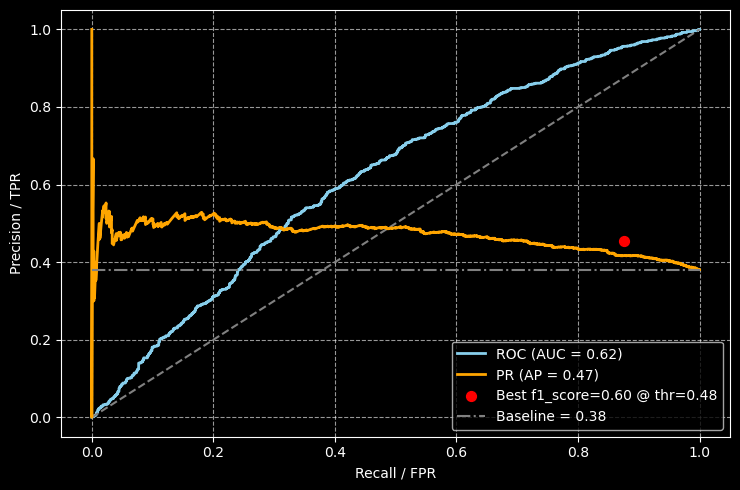

In [ ]:
model_bb_tb_time_uw = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time, weighting="uniqueness")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tb_time_uw, plot=True)

2025-10-12 00:47:41 | INFO     | Samples weighted by uniqueness.
2025-10-12 00:47:41 | INFO     | Average uniqueness: 0.9214
2025-10-12 00:47:41 | INFO     | Training on 12,142 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1971
           1       0.62      1.00      0.77      3232

    accuracy                           0.62      5203
   macro avg       0.31      0.50      0.38      5203
weighted avg       0.39      0.62      0.48      5203


Confusion Matrix:
[[   0 1971]
 [   0 3232]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      0.26      0.32      1971
           1  

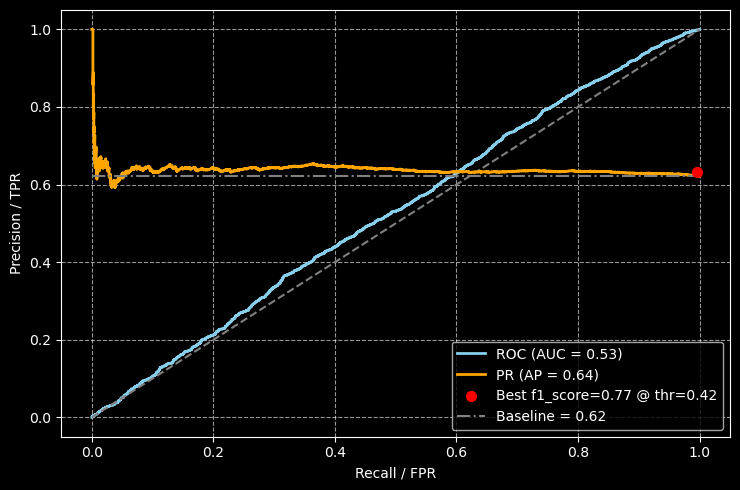

In [ ]:
model_bb_tb_time_uw1 = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time1, weighting="uniqueness")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tb_time_uw1, plot=True)

2025-10-11 21:20:15 | INFO     | Samples weighted by return attribution.
2025-10-11 21:20:15 | INFO     | Training on 5,478 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1453
           1       0.38      1.00      0.55       894

    accuracy                           0.38      2347
   macro avg       0.19      0.50      0.28      2347
weighted avg       0.15      0.38      0.21      2347


Confusion Matrix:
[[   0 1453]
 [   0  894]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      1.00      0.76      1453
           1       1.00      0.00      0.00       894

    accuracy

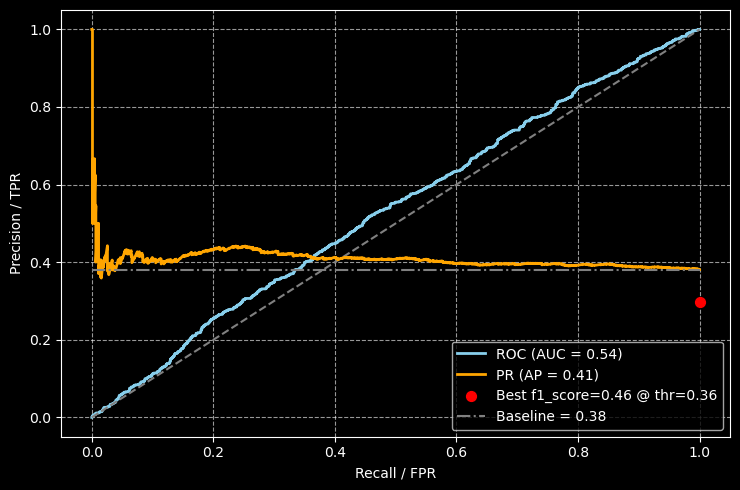

In [ ]:
model_bb_tb_time_rw = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tb_time_rw, plot=True)

2025-10-12 00:48:26 | INFO     | Samples weighted by return attribution.
2025-10-12 00:48:26 | INFO     | Average uniqueness: 0.9214
2025-10-12 00:48:26 | INFO     | Training on 12,142 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1971
           1       0.62      1.00      0.77      3232

    accuracy                           0.62      5203
   macro avg       0.31      0.50      0.38      5203
weighted avg       0.39      0.62      0.48      5203


Confusion Matrix:
[[   0 1971]
 [   0 3232]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.38      1.00      0.55      1971
      

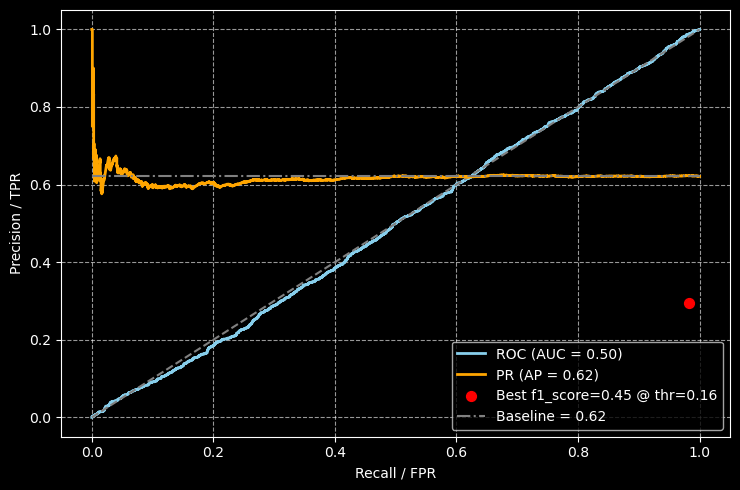

In [ ]:
model_bb_tb_time_rw1 = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time1, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tb_time_rw1, plot=True)

Reloading 'afml.backtester.training'.
2025-10-11 21:45:49 | INFO     | Samples weighted by time-decay
2025-10-11 21:45:49 | INFO     | Training on 5,478 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1453
           1       0.38      1.00      0.55       894

    accuracy                           0.38      2347
   macro avg       0.19      0.50      0.28      2347
weighted avg       0.15      0.38      0.21      2347


Confusion Matrix:
[[   0 1453]
 [   0  894]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.56      0.63      1453
           1       0.47      0.63     

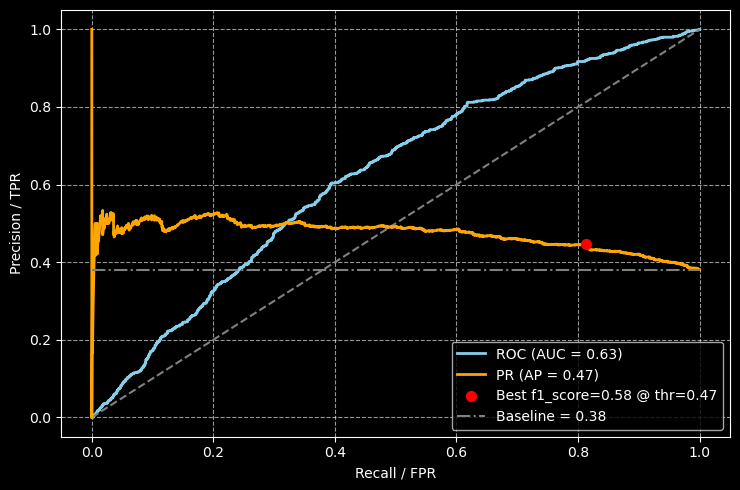

In [ ]:
model_bb_tb_time_tw = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time, weighting="time", time_decay=0.5)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tb_time_tw, plot=True)

In [ ]:
model_bb_tb_time_tw1 = train_model(model=rf, X=bb_feat_time, events=bb_events_tb_time1, weighting="time", time_decay=0.5)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_bb_tb_time_tw1, plot=True)

TypeError: get_weights_by_time_decay_optimized() got an unexpected keyword argument 'close_series_index'

##### Reports

In [ ]:
dirpath = Path("reports", "time_bars", bb_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

# Simulated loop over labeling methods
labeling_methods = [
    "triple-barrier_daily_vol", 
    f"triple-barrier_SMA{bb_period}", 
    ]
models = [model_bb_tb_time, model_bb_tb_time1]

In [ ]:
# fp = Path(dirpath, "unweighted")
# fp_plots = Path(dirpath, "plots", "unweighted")
# fp_plots.mkdir(parents=True, exist_ok=True)
# bb_models = [model_bb_fh_time, model_bb_tb_time, model_bb_trend_time]

# bb_roc = compare_roc_curves(
#     bb_models[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc = compare_roc_curves(bb_models[:2], plot_titles[:2], columns=2)
# # bb_roc.savefig(dirpath / "bb_roc_barrier_comparison.png", bbox_inches="tight", dpi=100)

# # bb_roc_trend = compare_roc_curves(bb_models[2:], plot_titles[2:], columns=2)
# # bb_roc_trend.savefig(dirpath / "bb_roc_trend_comparison.png", bbox_inches="tight", dpi=100)

# # meta_labelinglassification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

In [ ]:
# fp_w = Path(dirpath, "return_weighted") 
# fp_plots = Path(dirpath, "plots", "return_weighted")
# fp_plots.mkdir(parents=True, exist_ok=True)

# bb_models_w = [model_bb_fh_time_w, model_bb_tbtime_w, model_bb_trend_time_w]
# bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
# filenames_w = [f"{w}_w" for w in filenames]

# bbb_roc = compare_roc_curves(
#     bb_models_w[:], plot_titles[:], columns=2, height=7.5, 
#     fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
#     )
# bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

# meta_labelinglassification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

In [ ]:
# fp_tw = Path(dirpath, "time_weighted") 
# plot_titles_tw = [fr"$\lambda = {decay}$" for decay in time_decays]
# columns = 2
# height = 7.5
# fig_titles = [f"Time-Decay ($\lambda$): {method} ROC Curves" for method in bb_titles]

# bb_models_tw, bb_titles_tw, filenames_tw = [], [], []
# for time_decay, labels in models_bb_time_tw.items():
#     for i, (label, model) in enumerate(labels.items()):
#         bb_models_tw.append(model)
#         bb_titles_tw.append(f"Time-Weighted (λ = {time_decay}) {bb_titles[i]}")
#         filenames_tw.append(f"{filenames[i]}_tw_{time_decay}")

# meta_labelinglassification_reports(model_data=bb_models_tw, titles=bb_titles_tw, output_filenames=filenames_tw, path=fp_tw)

# fig_title = fig_titles[0]
# bb_roc_fh_tw = compare_roc_curves(bb_models_tw[::4], plot_titles_tw, fig_title, columns, height)
# bb_roc_fh_tw.savefig(dirpath / "bb_roc_fixed_horizon_comparison_time_weighted.png", bbox_inches="tight", dpi=100)

##### Out-of-Sample

In [ ]:


# Create events set for model
df = bb_time_bars[sample_end:]
close = df.close.copy()
target = get_daily_vol(bb_time_bars.close, vol_lookback).reindex(df.index) * bb_vol_multiplier

side, t_events = get_entries(bb_strategy, df, on_crossover=False)
vertical_barrier_times = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)

# Create feature set for model
X_test = bb_feat_time.reindex(t_events).dropna().copy()
value_counts_data(X_test.side, verbose=True)
X_test.info()


bb_events_tb_time_oos = get_events(
    close, t_events, 
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )
bb_events_tb_time_oos1 = get_events(
    close, t_events, 
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    target=close.rolling(bb_period).std().reindex(df.index), 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )
labeling_methods = [
    "triple-barrier_daily_vol", 
    "triple-barrier_SMA20", 

    ]
models = [
    model_bb_tb_time, model_bb_tb_time1,
    model_bb_tb_time_uw, model_bb_tb_time_uw1,
    model_bb_tb_time_rw, model_bb_tb_time_rw1,
    model_bb_tb_time_tw, model_bb_tb_time_tw1,
    ]
events_oos = {
              f"triple_barrier_daily_vol{vol_lookback}_unweighted": bb_events_tb_time_oos,
              f"triple_barrier_SMA{bb_period}_unweighted": bb_events_tb_time_oos1,
              f"triple_barrier_daily_vol{vol_lookback}_uniqueness_weighted": bb_events_tb_time_oos,
              f"triple_barrier_SMA{bb_period}_uniqueness_weighted": bb_events_tb_time_oos1,
              f"triple_barrier_daily_vol{vol_lookback}_return_weighted": bb_events_tb_time_oos,
              f"triple_barrier_SMA{bb_period}_return_weighted": bb_events_tb_time_oos1,
              f"triple_barrier_daily_vol{vol_lookback}_time_weighted": bb_events_tb_time_oos,
              f"triple_barrier_SMA{bb_period}_time_weighted": bb_events_tb_time_oos1,
              }

2025-09-22 19:27:12 | INFO     | Bollinger_w20_std1.5 | 71,159 (100.00%) trade events.

       count  proportion
side                    
-1    35,933    0.504968
 1    35,226    0.495032

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71159 entries, 2021-12-31 02:40:00 to 2024-12-31 00:00:00
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   close                71159 non-null  float32
 1   spread               71159 non-null  float32
 2   vol                  71159 non-null  float32
 3   h1_vol               71159 non-null  float32
 4   h4_vol               71159 non-null  float32
 5   d1_vol               71159 non-null  float32
 6   ret                  71159 non-null  float32
 7   ret_5                71159 non-null  float32
 8   ret_10               71159 non-null  float32
 9   ret_1_lag_1          71159 non-null  float32
 10  ret_5_lag_1          71159 non-null  float32
 11  ret_10_lag_1

In [ ]:
bet_sizing_methods = [None, 'probability', 'budget', 'reserve', 'dynamic']
bet_sizing = bet_sizing_methods[0]

if bet_sizing == "probability":
    bet_sizing_args = dict(step_size=0.0, average_active=False)
else:
    bet_sizing_args = dict()

bb_model_results_time = {}
time_metrics_oos = {"primary_model": {}, "meta_model": {}}
bb_metrics_time = pd.DataFrame()

In [ ]:
i, j = 2, 6
for model_name, model in zip(labeling_methods[i : j], models[i : j]):
    prob = model.fit.predict_proba(X_test)[:, 1]
    prob = pd.Series(prob, index=X_test.index)
    name = f"{bb_strategy.get_strategy_name()} ({model_name.replace('_', ' ').title()})"
    results = run_meta_labeling_analysis(
        events=events_oos[model_name],
        meta_probabilities=prob,
        close=close,
        confidence_threshold=0.5,
        strategy_name=name,
        bet_sizing=bet_sizing,
        **bet_sizing_args
        )
    bb_model_results_time[model_name] = results
    bb_metrics_time[model_name] = results["meta_metrics"]

bb_metrics_time

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- ts_bin
- ts_prob


In [ ]:
for model_name, model in zip(
    ["unweighted", "uniqueness_weighted", "return_weighted", "time_weighted"], 
    [model_bb_tb_time, model_bb_tb_time_uw, model_bb_tb_time_rw, model_bb_tb_time_tw]
    ):
    prob = model.fit.predict_proba(X_test)[:, 1]
    prob = pd.Series(prob, index=X_test.index)

    results = run_meta_labeling_analysis(
        events=bb_events_tb_time_oos,
        meta_probabilities=prob,
        close=close,
        confidence_threshold=0.5,
        strategy_name=bb_strategy.get_strategy_name(),
        bet_sizing=bet_sizing,
        **bet_sizing_args
        )
    bb_model_results_time[f"triple_barrier_{model_name}"] = results
    bb_metrics_time[f"triple_barrier_{model_name}"] = results["meta_metrics"]

bb_metrics_time


Meta-Labeling Performance Analysis: Bollinger_w20_std1.5

Signal Filtering Summary:
  Total Primary Signals: 71,147
  Filtered Signals: 53,966
  Filter Rate: 24.15%
  Confidence Threshold: 0.5

CORE PERFORMANCE METRICS       Primary         Meta-Labeled    Improvement    
Total Return                   1,731.29%       1,444.67%       -16.6%         
Annualized Return              163.53%         148.99%         -8.9%          
Sharpe Ratio                   6.8280          8.5534          +25.3%         
Sortino Ratio                  8.9424          11.1258         +24.4%         
Calmar Ratio                   3.4373          3.8842          +13.0%         

RISK METRICS                   Primary         Meta-Labeled    Improvement    
Max Drawdown                   47.57%          38.36%          +19.4%         
Avg Drawdown                   2.75%           2.17%           +21.0%         
Volatility (Ann.)              0.4576          0.4501          +1.7%          
Downside Volat

,fixed_horizon_unweighted,fixed_horizon_return_weighted,triple_barrier_unweighted,triple_barrier_return_weighted
total_return,4.822452,4.822452,14.44669,14.44669
annualized_return,0.798776,0.798776,1.489935,1.489935
volatility,0.559781,0.559781,0.450077,0.450077
downside_volatility,0.423702,0.423702,0.346015,0.346015
sharpe_ratio,4.589304,4.589304,8.553424,8.553424
sortino_ratio,6.063234,6.063234,11.125808,11.125808
var_95,-0.003023,-0.003023,-0.002772,-0.002772
cvar_95,-0.004956,-0.004956,-0.004075,-0.004075
skewness,0.0221,0.0221,-0.458396,-0.458396
kurtosis,7.986032,7.986032,4.150295,4.150295


In [ ]:
model = model_bb_trend_time
# opt_threshold = get_optimal_threshold(model)

events = get_events(
    close, t_events, 
    pt_sl=[0, bb_sl_barrier], 
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=bb_side,
    )

prob = model.fit.predict_proba(X_test)[:, 1]
prob = pd.Series(prob, index=X_test.index)

results = run_meta_labeling_analysis(
    events=events,
    meta_probabilities=prob,
    close=close,
    # confidence_threshold=opt_threshold["threshold"],
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name(),
    bet_sizing=bet_sizing,
    **bet_sizing_args
    )
bb_model_results_time["trend_scanning"] = results


Meta-Labeling Performance Analysis: Bollinger_w20_std1.5

Signal Filtering Summary:
  Total Primary Signals: 71,147
  Filtered Signals: 31,030
  Filter Rate: 56.39%
  Confidence Threshold: 0.5

CORE PERFORMANCE METRICS       Primary         Meta-Labeled    Improvement    
Total Return                   1,272.20%       476.33%         -62.6%         
Annualized Return              139.36%         79.27%          -43.1%         
Sharpe Ratio                   5.3004          6.4379          +21.5%         
Sortino Ratio                  8.3059          10.6801         +28.6%         
Calmar Ratio                   3.5156          2.3522          -33.1%         

RISK METRICS                   Primary         Meta-Labeled    Improvement    
Max Drawdown                   39.64%          33.70%          +15.0%         
Avg Drawdown                   3.52%           3.49%           +0.8%          
Volatility (Ann.)              0.5408          0.6842          -26.5%         
Downside Volat

In [ ]:
from afml.bet_sizing.bet_sizing import bet_size_budget

bet_size_budget(events.t1, events.side)

,t1,side,active_long,active_short,bet_size
time,,,,,
2021-12-31 02:40:00,2021-12-31 06:50:00,1,1,0,0.026316
2021-12-31 02:50:00,2021-12-31 07:00:00,1,2,0,0.052632
2021-12-31 02:55:00,2021-12-31 07:05:00,1,3,0,0.078947
2021-12-31 03:00:00,2021-12-31 07:10:00,1,4,0,0.105263
2021-12-31 03:05:00,2021-12-31 07:15:00,1,5,0,0.131579
...,...,...,...,...,...
2024-12-30 21:00:00,NaT,-1,1,1,0.004577
2024-12-30 22:00:00,NaT,1,0,1,-0.021739
2024-12-30 23:45:00,NaT,-1,0,0,0.000000


In [ ]:
time_metrics_oos = {}
for col, res in bb_model_results_time.items():
    time_metrics_oos.setdefault("primary_model", []).append(pd.Series(res["primary_metrics"], name=col))
    time_metrics_oos.setdefault("meta_model", []).append(pd.Series(res["meta_metrics"], name=col))

primary_metrics_df = pd.concat(time_metrics_oos["primary_model"], axis=1)
meta_metrics_df = pd.concat(time_metrics_oos["meta_model"], axis=1)
# pprint(time_metrics_oos)
primary_metrics_df

,fixed_horizon,triple_barrier
total_return,-1.0,17.31286
annualized_return,-1.0,1.637588
volatility,7.366913,0.457624
downside_volatility,4.559798,0.349421
sharpe_ratio,-24.175337,6.827811
sortino_ratio,-39.05822,8.94214
var_95,-0.084407,-0.002857
cvar_95,-0.104764,-0.004129
skewness,0.102362,-0.49109
kurtosis,0.172942,3.462621


In [ ]:
meta_metrics_df

,fixed_horizon,triple_barrier
total_return,-1.0,6.835008
annualized_return,-1.0,0.987089
volatility,7.366913,0.444707
downside_volatility,4.559798,0.339417
sharpe_ratio,-24.175337,8.599693
sortino_ratio,-39.05822,11.267396
var_95,-0.084407,-0.002678
cvar_95,-0.104764,-0.003993
skewness,0.102362,-0.442031
kurtosis,0.172942,4.331774


In [ ]:
bet_sizes_raw = bet_size_probability(
            events,
            prob.reindex(events.index),
            num_classes=2,
            pred=events.side,
            # **kwargs,
        )
# bet_sizes_raw.describe()
pd.concat([bet_sizes_raw, prob], axis=1).dropna()[bet_sizes_raw < 0]

,bet_size,0
time,,
2021-12-31 02:40:00,-0.041191,0.474210
2021-12-31 02:50:00,-0.044235,0.472308
2021-12-31 04:35:00,-0.014694,0.490793
2021-12-31 07:00:00,-0.037061,0.476792
2021-12-31 08:35:00,-0.002270,0.498578
...,...,...
2024-12-30 11:50:00,-0.093214,0.558149
2024-12-30 13:25:00,-0.050949,0.531885
2024-12-30 13:55:00,-0.032719,0.520492


In [ ]:
pd.concat([results["primary_returns"], results["meta_returns"]], axis=1)

,0,1
time,,
2021-12-31 02:40:00,0.000093,0.000000
2021-12-31 02:50:00,-0.001051,-0.000000
2021-12-31 03:35:00,-0.000429,-0.000429
2021-12-31 04:35:00,-0.000919,-0.000000
2021-12-31 06:05:00,0.000932,-0.000000
...,...,...
2024-12-30 14:10:00,0.001043,-0.001043
2024-12-30 15:15:00,-0.002965,-0.002965
2024-12-30 15:30:00,-0.002764,-0.002764


In [ ]:
model = model_bb_trend_time
# opt_threshold = get_optimal_threshold(model)

events = get_events(
    close, t_events, 
    pt_sl=[0, 0],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=primary_signals,
    ).dropna(subset=["t1"])

prob = model.fit.predict_proba(X_test)[:, 1]
prob = pd.Series(prob, index=X_test.index)

results = run_meta_labeling_analysis(
    close,
    events,
    prob,
    confidence_threshold=0.5,
    strategy_name=bb_strategy.get_strategy_name()
    )
bb_model_results_time[f"trend_scanning_{volatility_threshold}"] = results

NameError: name 'model_bb_trend_time' is not defined

In [ ]:
# # meta_positions = (prob > 0.44).astype("int8")
# # value_counts_data(meta_positions)
# fit = model_bb_fh_time.fit
# prob = pd.Series(fit.predict_proba(X_test)[:, 1], index=X_test.index)

# bet_sizes_raw = bet_size_probability(
#         events,
#         prob,
#         num_classes=2,
#         pred=events['side'],
#         step_size=0,
#         average_active=0,
#     )
# bet_sizes_raw.describe()

### Tick-Bars

In [25]:
bb_side = bb_strategy.generate_signals(bb_tick_bars)
bb_df = bb_tick_bars.loc[sample_start : sample_end]

print(f"{bb_strategy.get_strategy_name()} Signals:")
value_counts_data(bb_side.reindex(bb_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = 100
vol_target = get_daily_vol(bb_df.close, vol_lookback) * bb_vol_multiplier
close = bb_df.close

thres = vol_target.mean()
side, t_events = get_entries(bb_strategy, bb_df, filter_threshold=thres)

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(bb_timeframe) if x.isnumeric()))
bb_tick_horizon = bb_time_horizon * tm
if bb_timeframe.startswith("H"):
    bb_tick_horizon *= 60
elif bb_timeframe.startswith("D"):
    bb_tick_horizon *= 60 * 24

h = timedelta(minutes=bb_tick_horizon)
print(f"Time Horizon: {h}")
vertical_barriers_by_time = add_vertical_barrier(t_events, close, minutes=bb_tick_horizon)
# vertical_barriers_by_num_bars = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)

Bollinger_w20_std1.5 Signals:

        count  proportion
side                     
 0    297,722    0.696537
 1     65,015    0.152106
-1     64,695    0.151357

2025-10-13 20:23:01 | INFO     | 14,777 CUSUM-filtered events
2025-10-13 20:23:01 | INFO     | Bollinger_w20_std1.5 | 12,921 (9.96%) trade events selected by CUSUM filter (threshold = 0.1263%).
Time Horizon: 4:10:00


#### Feature Engineering

In [26]:
# No shifting b/c mean-reversion seems to benefit from contemporaneous information
bb_feat = create_bollinger_features(bb_tick_bars, bb_period, bb_std)
bb_feat.info()

bb_feat_tick = bb_feat.copy()
# not_stationary = is_stationary(bb_feat_tick.dropna())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 871431 entries, 2018-01-03 00:03:55.027001 to 2024-12-30 23:57:20.455001
Data columns (total 47 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   close                871431 non-null  float32
 1   spread               871431 non-null  float32
 2   vol                  871431 non-null  float32
 3   h1_vol               871431 non-null  float32
 4   h4_vol               871431 non-null  float32
 5   d1_vol               871431 non-null  float32
 6   ret                  871431 non-null  float32
 7   ret_5                871431 non-null  float32
 8   ret_10               871431 non-null  float32
 9   ret_1_lag_1          871431 non-null  float32
 10  ret_5_lag_1          871431 non-null  float32
 11  ret_10_lag_1         871431 non-null  float32
 12  ret_1_lag_2          871431 non-null  float32
 13  ret_5_lag_2          871431 non-null  float32
 14  ret_10_lag_2        

#### Triple-Barrier Method

In [27]:
bb_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_by_time,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tb = get_event_weights(bb_events_tb, close)
bb_events_tb_tick = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={h}):")
value_counts_data(bb_events_tb.bin, verbose=True)


ret = bb_events_tb.ret
sr_bb_tbl = ret.mean() / ret.std()
av_uniqueness = bb_events_tb['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")

Triple-Barrier (pt=1, sl=2, h=4:10:00):

     count  proportion
bin                   
0    7,048    0.545891
1    5,863    0.454109


Average Uniqueness: 0.5754


In [28]:
bb_events_tb = triple_barrier_labels(
    close=close,
    target=close.rolling(bb_period).std(),
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers_by_time,
    side_prediction=bb_side.loc[close.index],
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tb = get_event_weights(bb_events_tb, close)
bb_events_tb_tick1 = bb_events_tb.copy()
print(f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={h}):")
value_counts_data(bb_events_tb.bin, verbose=True)


ret = bb_events_tb.ret
sr_bb_tbl = ret.mean() / ret.std()
av_uniqueness1 = bb_events_tb['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness1:.4f}")

Triple-Barrier (pt=1, sl=2, h=4:10:00):

     count  proportion
bin                   
1    8,204    0.634935
0    4,717    0.365065


Average Uniqueness: 0.9343


#### Random Forest

#### Cross-Validation of Weighting Methods

In [29]:
random_state = 1
min_w_leaf = 0.05

clf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=100,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

In [31]:
cont = bb_events_tb_tick.copy()
X = bb_feat_tick.reindex(cont.index)
y = cont["bin"]
t1 = cont["t1"]

test_size = 0.25
n_splits = 7
pct_embargo = 0.01

train, test = PurgedSplit(t1, test_size).split(X)
X_train, X_test, y_train, y_test = (
        X.iloc[train],
        X.iloc[test],
        y.iloc[train],
        y.iloc[test],
    )

In [32]:
decay_factors = [0.25, 0.5, 0.75]
time_decay_weights = {}
for time_decay in decay_factors:
    for linear in (1, 0):
        decay_w = get_weights_by_time_decay_optimized(
                    triple_barrier_events=cont,
                    close_index=close.index,
                    decay=time_decay,
                    linear=linear,
                    av_uniqueness=cont["tW"],
                )
        method = "linear" if linear else "exp"
        time_decay_weights[f"{method}_time_decay_{time_decay}"] = decay_w
        # time_decay_weights[f"{method}_time_decay_{time_decay}_uniqueness"] = decay_w * cont["tW"]
        # time_decay_weights[f"{method}_time_decay_{time_decay}_return_attribution"] = decay_w * cont["w"]
    
weighting_schemes = {
    "none": pd.Series(1., index=cont.iloc[train].index),
    "uniqueness": cont["tW"].iloc[train],
    "return-attribution": cont["w"].iloc[train],
    }

for k, v in time_decay_weights.items():
    weighting_schemes[k] = v.iloc[train]
    # if k.startswith('exp'):
    #     weighting_schemes[k.replace('exp_', '')] = v.iloc[train]

weighting_schemes.keys()

dict_keys(['none', 'uniqueness', 'return-attribution', 'linear_time_decay_0.25', 'exp_time_decay_0.25', 'linear_time_decay_0.5', 'exp_time_decay_0.5', 'linear_time_decay_0.75', 'exp_time_decay_0.75'])

In [33]:
cv_gen = PurgedKFold(n_splits, t1.iloc[train], pct_embargo)
cv_scores_d = {}
print(clf.__class__.__name__, "Weighting Schemes")

for scheme, sample_weights in weighting_schemes.items():
    print(f"\n{scheme}:")
    w = sample_weights.values
    cv_scores = ml_cross_val_scores_all(
        clf, X_train, y_train, cv_gen, 
        sample_weight_train=w, 
        sample_weight_score=w,
    )
    cv_scores_d[scheme] = cv_scores
    for scoring, cv_score in cv_scores.items():
        print(f"  {scoring}: μ = {cv_score.mean():.6f}, σ = {cv_score.std():.6f}")


RandomForestClassifier Weighting Schemes

none:
  accuracy_score: μ = 0.539717, σ = 0.035141
  probability_weighted_accuracy: μ = 0.554466, σ = 0.048494
  neg_log_loss: μ = -0.690928, σ = 0.007685
  f1_score: μ = 0.415696, σ = 0.232696

uniqueness:
  accuracy_score: μ = 0.531251, σ = 0.032299
  probability_weighted_accuracy: μ = 0.547715, σ = 0.042058
  neg_log_loss: μ = -0.692142, σ = 0.007012
  f1_score: μ = 0.455383, σ = 0.226689

return-attribution:
  accuracy_score: μ = 0.642829, σ = 0.026901
  probability_weighted_accuracy: μ = 0.643026, σ = 0.028597
  neg_log_loss: μ = -0.654320, σ = 0.015510
  f1_score: μ = 0.000000, σ = 0.000000

linear_time_decay_0.25:
  accuracy_score: μ = 0.537742, σ = 0.034360
  probability_weighted_accuracy: μ = 0.558193, σ = 0.051223
  neg_log_loss: μ = -0.689769, σ = 0.008428
  f1_score: μ = 0.408817, σ = 0.233897

exp_time_decay_0.25:
  accuracy_score: μ = 0.536231, σ = 0.033157
  probability_weighted_accuracy: μ = 0.558023, σ = 0.050995
  neg_log_loss

In [34]:
cv_scores_mu_df_tick = pd.DataFrame(index=cv_scores_d.keys()) 
cv_scores_std_df_tick = pd.DataFrame(index=cv_scores_d.keys()) 


for idx, dict_ in cv_scores_d.items():
    for key, val in dict_.items():
        col = key.replace('_score', '').replace('probability_weighted_accuracy', 'PWA')
        cv_scores_mu_df_tick.loc[idx, col] = val.mean()
        cv_scores_std_df_tick.loc[idx, col] = val.std()

print(f"Mean of CV Scores: \n{cv_scores_mu_df_tick}")
print(f"\nStd of CV Scores: \n{cv_scores_std_df_tick}")        

Mean of CV Scores: 
                        accuracy       PWA  neg_log_loss        f1
none                    0.539717  0.554466     -0.690928  0.415696
uniqueness              0.531251  0.547715     -0.692142  0.455383
return-attribution      0.642829  0.643026     -0.654320  0.000000
linear_time_decay_0.25  0.537742  0.558193     -0.689769  0.408817
exp_time_decay_0.25     0.536231  0.558023     -0.689805  0.407846
linear_time_decay_0.5   0.534411  0.556086     -0.690302  0.407162
exp_time_decay_0.5      0.535033  0.555772     -0.690390  0.404528
linear_time_decay_0.75  0.539664  0.555164     -0.690695  0.412444
exp_time_decay_0.75     0.539994  0.555106     -0.690730  0.413164

Std of CV Scores: 
                        accuracy       PWA  neg_log_loss        f1
none                    0.035141  0.048494      0.007685  0.232696
uniqueness              0.032299  0.042058      0.007012  0.226689
return-attribution      0.026901  0.028597      0.015510  0.000000
linear_time_decay_0.25

In [ ]:
train_ = train[:1000]

base_rf = RandomForestClassifier(n_estimators=1, criterion="entropy", class_weight="balanced_subsample", bootstrap=False)
seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=t1[train_],
    price_bars_index=close.index,
    # estimator=base_rf,
    random_state=42,
    n_jobs=-1,
    verbose=True,
)

seq_fit = seq_rf.fit(X.iloc[train_], y[train_], sample_weight=cont["w"][train_])

# print("SequentiallyBootstrappedBaggingClassifier")
# for scheme, sample_weights in weighting_schemes.items():
#     print(f"\n{scheme}:")
#     w = sample_weights.values
#     cv_scores = ml_cross_val_scores_all(
#         seq_rf, X_train, y_train, cv_gen, 
#         sample_weight_train=w, 
#         sample_weight_score=w,
#     )
#     cv_scores_d[scheme] = cv_scores
#     for scoring, cv_score in cv_scores.items():
#         print(f"  {scoring}: μ = {cv_score.mean():.6f}, σ = {cv_score.std():.6f}")

Reloading 'afml.sampling.optimized_bootstrapping'.
Reloading 'afml.sampling.optimized_sb_bagging'.


[autoreload of afml.sampling.optimized_bootstrapping failed: Traceback (most recent call last):
  File "c:\Users\JoeN\miniforge3\envs\mlfinlab_env\lib\site-packages\IPython\extensions\autoreload.py", line 274, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "c:\Users\JoeN\miniforge3\envs\mlfinlab_env\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "c:\Users\JoeN\miniforge3\envs\mlfinlab_env\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks\..\afml\sampling\optimized_bootstrapping.py", line 8, in <module>
    from sklearn.base import BaseEstimator, ClassifierMixin, check_X_y, check_a

AttributeError: 'SequentiallyBootstrappedBaggingClassifier' object has no attribute '_seeds'

In [ ]:
# dashes = "-" * 60
# volatility_threshold = 0.1
# volatility_threshold_mr = 0.85

# plot_titles = [
#     f"Fixed-Time Horizon (h = {bb_time_horizon})", 
#     f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
#     fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
#     fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
#     ]
# bb_titles = [
#     "Fixed-Time Horizon", 
#     "Triple-Barrier",
#     f"Trend-Scanning (σ = {volatility_threshold})",
#     f"Trend-Scanning (σ = {volatility_threshold_mr})"
#     ]

# name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
# filenames = [
#     f"{name}_fixed_horizon",
#     f"{name}_triple_barrier",
#     f"{name}_trend_scanning_{volatility_threshold}",
#     f"{name}_trend_scanning_{volatility_threshold_mr}"
#     ]
# print(f"Strategy: {bb_strategy.get_strategy_name()}")

# random_state = 52
# min_w_leaf = 0.05

# rf = RandomForestClassifier(
#     criterion='entropy',
#     n_estimators=1000,
#     class_weight='balanced_subsample',
#     random_state=random_state,
#     min_weight_fraction_leaf=min_w_leaf,
#     n_jobs=-1,  # Use all available cores
#     )

Strategy: Bollinger_w20_std1.5


##### Unweighted

In [ ]:
model_bb_tb_tick = train_model(model=rf, X=bb_feat_tick, events=bb_events_tb_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_tb_tick, plot=True)

Reloading 'afml.backtester.training'.


TypeError: argument of type 'NoneType' is not iterable

In [ ]:
model_bb_tb_tick1 = train_model(model=rf, X=bb_feat_tick, events=bb_events_tb_tick1)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_tb_tick1, plot=True)

TypeError: train_model() got an unexpected keyword argument 'features'

##### Return-Weighted

In [ ]:
model_bb_tb_tick_rw = train_model(model=rf, features=bb_feat_tick, events=bb_events_tb_tick, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_tb_tick_rw, plot=True)

In [ ]:
model_bb_tb_tick_uw = train_model(model=rf, features=bb_feat_tick, events=bb_events_tb_tick, weighting="uniqueness")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_tb_tick_uw, plot=True)

In [ ]:
model_bb_tb_tick_tw = train_model(model=rf, features=bb_feat_tick, events=bb_events_tb_tick, weighting="time")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_bb_tb_tick_tw, plot=True)

##### Reports

In [ ]:
dirpath = Path("reports", "tick_bars", f"tick-{bb_tick_bars.tick_volume.iloc[0]}")
dirpath.mkdir(parents=True, exist_ok=True)

plot_titles = [
    f"Fixed-Time Horizon (h = {bb_time_horizon})", 
    f"Triple-Barrier (pt = {bb_pt_barrier}, sl = {bb_sl_barrier}, h = {bb_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]
print(f"Strategy: {bb_strategy.get_strategy_name()}")

In [ ]:
bb_models = [model_bb_fh_tick, model_bb_tb_tick, model_bb_trend_tick, model_bb_trend_mr_tick]
fp = Path(dirpath, "unweighted") 
fp.mkdir(parents=True, exist_ok=True)

fp_plots = Path(dirpath, "plots", "unweighted")
fp_plots.mkdir(parents=True, exist_ok=True)

bb_roc = compare_roc_curves(
    bb_models[:], plot_titles[:], columns=2, height=7.5, 
    fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)"
    )
bb_roc.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)


meta_labeling_classification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

In [ ]:
fp_w = Path(dirpath, "return_weighted") 
bb_models_w = [model_bb_fh_tick_w, model_bb_tb_tick_w, model_bb_trend_tick_w, model_bb_trend_mr_tick_w]
bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
filenames_w = [f"{w}_w" for w in filenames]

fp_plots = Path(dirpath, "plots", "return_weighted")
fp_plots.mkdir(parents=True, exist_ok=True)

bb_roc_w = compare_roc_curves(bb_models_w[:], plot_titles[:], columns=2, height=7.5, fig_title=f"Bollinger Strategy (window= {bb_period}, $\\sigma = {bb_std}$)")
bb_roc_w.savefig(fp_plots / "bb_roc_comparison.png", bbox_inches="tight", dpi=100)

meta_labelling_classification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

##### Out-of-Sample

In [ ]:
bb_models_w = [model_bb_fh_tick_w, model_bb_tb_tick_w, model_bb_trend_tick_w, model_bb_trend_mr_tick_w]
model_preds_tick_w = {}
tick_metrics_oos_w = {}
X = bb_feat_tick.loc[sample_end:]
df_oos = bb_tick_bars.loc[sample_end:]

for i, model in enumerate(bb_models_w):
    df, metrics = backtest_model(model.fit, X, df_oos.close)
    model_preds_tick_w[bb_titles[i]] = df
    tick_metrics_oos_w[filenames[i]] = metrics
    print(f"{bb_titles[i]} done.")

tick_metrics_oos_df_w = pd.DataFrame(tick_metrics_oos_w)
tick_metrics_oos_df_w

#### Time- vs. Tick-Bars

In [ ]:
titles = ["Time-Bars", "Tick-Bars"]
title = "Fixed-Time Horizon Method"
roc_pr = compare_roc_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

In [ ]:
titles = ["Time-Bars", "Tick-Bars"]
title = "Fixed-Time Horizon Method"
roc_pr = compare_roc_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

In [ ]:
pr = compare_pr_curves([model_bb_fh_time, model_bb_fh_tick], titles, fig_title=title, columns=2, height=5)

In [ ]:
model_names = ["Fixed-Time Horizon", "Triple-Barrier"]
titles = [
    f"Fixed-Time Horizon", 
    fr"Triple-Barrier ($\mathit{{pt}}$={bb_pt_barrier}, "
    fr"$\mathit{{sl}}$={bb_sl_barrier})",
    ]
title = fr"Time-Bars ($\mathit{{h}}$ = {timedelta(minutes=bb_tick_horizon)})"
model_data_list = [model_bb_fh_time, model_bb_tb_time] #, model_bb_tb_tick, model_bb_tb_tick_w]
metric = "f1"
n = 3

fig, summary_df = compare_roc_pr_curves(
    model_data=model_data_list[:n],
    model_names=model_names[:n],
    titles=titles[:n],
    fig_title=title,
    columns=2,
    metric=metric,
    height=5,
    show_baseline=True
)

summary_df
# summary_df.to_html("roc_pr_dual_metrics.html", float_format="%.3f")

In [ ]:
model_names = ["Fixed-Time Horizon", "Triple-Barrier"]
titles = [
    f"Fixed-Time Horizon", 
    fr"Triple-Barrier ($\mathit{{pt}}$={bb_pt_barrier}, "
    fr"$\mathit{{sl}}$={bb_sl_barrier})",
    ]
title = fr"Tick-Bars ($\mathit{{h}}$ = {timedelta(minutes=bb_tick_horizon)})"
model_data_list = [model_bb_fh_tick, model_bb_tb_tick] #, model_bb_tb_tick, model_bb_tb_tick_w]
n = 3

fig, summary_df = compare_roc_pr_curves(
    model_data=model_data_list[:n],
    model_names=model_names[:n],
    titles=titles[:n],
    fig_title=title,
    columns=2,
    metric=metric,
    height=5,
    show_baseline=True
)

summary_df.round(2)
# summary_df.to_html("roc_pr_dual_metrics.html", float_format="%.3f")

## 3. Moving Average Crossover Strategy

In [46]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

ma_timeframe = "M5"
tick_bar_size = tick_bar_dict.get(ma_timeframe)
ma_time_bars, ma_tick_bars = get_data(symbol, ma_timeframe)
ma_bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"

fast_window, slow_window = 20, 50
ma_strategy = MACrossoverStrategy(fast_window, slow_window)
ma_pt_barrier, ma_sl_barrier, ma_time_horizon = (0, 2, 100)
ma_vol_multiplier = 1
time_decay = 0.5
linear_decay = False

Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


### Time-Bars

In [47]:
ma_side = ma_strategy.generate_signals(ma_time_bars)
ma_df = ma_time_bars.loc[sample_start : sample_end]

print(f"{ma_strategy.get_strategy_name()} Signals:")
value_counts_data(ma_side.reindex(ma_df.index), verbose=True)

# Volatility target for barriers
vol_lookback = fast_window
vol_target = get_daily_vol(ma_df.close, vol_lookback) * ma_vol_multiplier
close = ma_df.close

thres = vol_target.mean()
_, t_events = get_entries(ma_strategy, ma_df, filter_threshold=None)
_, t_events_h = get_entries(ma_strategy, ma_df, filter_threshold=vol_target.mean())
_, t_events_series = get_entries(ma_strategy, ma_df, filter_threshold=vol_target)

vertical_barriers = add_vertical_barrier(t_events, close, num_bars=ma_time_horizon)
linear_decay = False

MACrossover_20_50 Signals:

        count  proportion
side                     
 1    149,741    0.506469
-1    145,866    0.493362
 0         50    0.000169

2025-10-13 23:00:30 | INFO     | MACrossover_20_50 | 6,888 (2.33%) trade events generated from crossovers.
2025-10-13 23:00:30 | INFO     | 32,809 CUSUM-filtered events
2025-10-13 23:00:30 | INFO     | MACrossover_20_50 | 32,804 (11.10%) trade events selected by CUSUM filter (threshold = 0.0622%).
2025-10-13 23:00:30 | INFO     | 43,188 CUSUM-filtered events
2025-10-13 23:00:31 | INFO     | MACrossover_20_50 | 43,188 (14.61%) trade events selected by CUSUM filter using series.


#### Feature Engineering

In [48]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_time_bars, ma_timeframe, lr_period=(5, fast_window))
ma_feat = ma_feat.join(ma_side, how="inner")
ma_feat_time = ma_feat.copy()
# ma_feat_time.info()

Memory usage reduced from 323.86 MB to 170.48 MB (47.4% reduction)


In [49]:
for i, col in enumerate(ma_feat_time):
    print(f"{i:>3}. {col}")

  0. ma_10
  1. ma_20
  2. ma_50
  3. ma_100
  4. ma_200
  5. ma_10_20_cross
  6. ma_20_50_cross
  7. ma_50_200_cross
  8. ma_spread_10_20
  9. ma_spread_20_50
 10. ma_spread_50_200
 11. ma_20_slope
 12. ma_50_slope
 13. price_above_ma_20
 14. price_above_ma_50
 15. ma_ribbon_aligned
 16. atr_14
 17. atr_21
 18. atr_regime
 19. realized_vol_10
 20. realized_vol_20
 21. realized_vol_50
 22. vol_of_vol
 23. hl_range
 24. hl_range_ma
 25. hl_range_regime
 26. bb_upper
 27. bb_lower
 28. bb_percent
 29. bb_bandwidth
 30. bb_squeeze
 31. efficiency_ratio_14
 32. efficiency_ratio_30
 33. adx_14
 34. dmp_14
 35. dmn_14
 36. adx_trend_strength
 37. adx_trend_direction
 38. trend_window
 39. trend_slope
 40. trend_t_value
 41. trend_rsquared
 42. trend_ret
 43. roc_10
 44. roc_20
 45. momentum_14
 46. hh_ll_20
 47. trend_persistence
 48. return_skew_20
 49. return_kurtosis_20
 50. var_95
 51. cvar_95
 52. market_stress
 53. current_drawdown
 54. days_since_high
 55. hour_sin_h1
 56. hour_cos_h1

#### Triple-Barrier Method

In [50]:
ma_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=False,
    verbose=False,
)
ma_events_tb = get_event_weights(ma_events_tb, close)
ma_events_tb_time = ma_events_tb.copy()
ma_events_tb.info()

print(f"Triple-Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon}):")
value_counts_data(ma_events_tb.bin, verbose=True)

av_uniqueness = ma_events_tb['tW'].mean()
print(f"Average Uniqueness: {av_uniqueness:.4f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6879 entries, 2018-01-03 02:30:00 to 2021-12-31 13:55:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      6879 non-null   datetime64[ns]
 1   trgt    6879 non-null   float64       
 2   ret     6879 non-null   float64       
 3   bin     6879 non-null   int8          
 4   side    6879 non-null   int8          
 5   tW      6879 non-null   float64       
 6   w       6879 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int8(2)
memory usage: 335.9 KB
Triple-Barrier (pt=0, sl=2, h=100):

     count  proportion
bin                   
0    4,535    0.659253
1    2,344    0.340747

Average Uniqueness: 0.5925


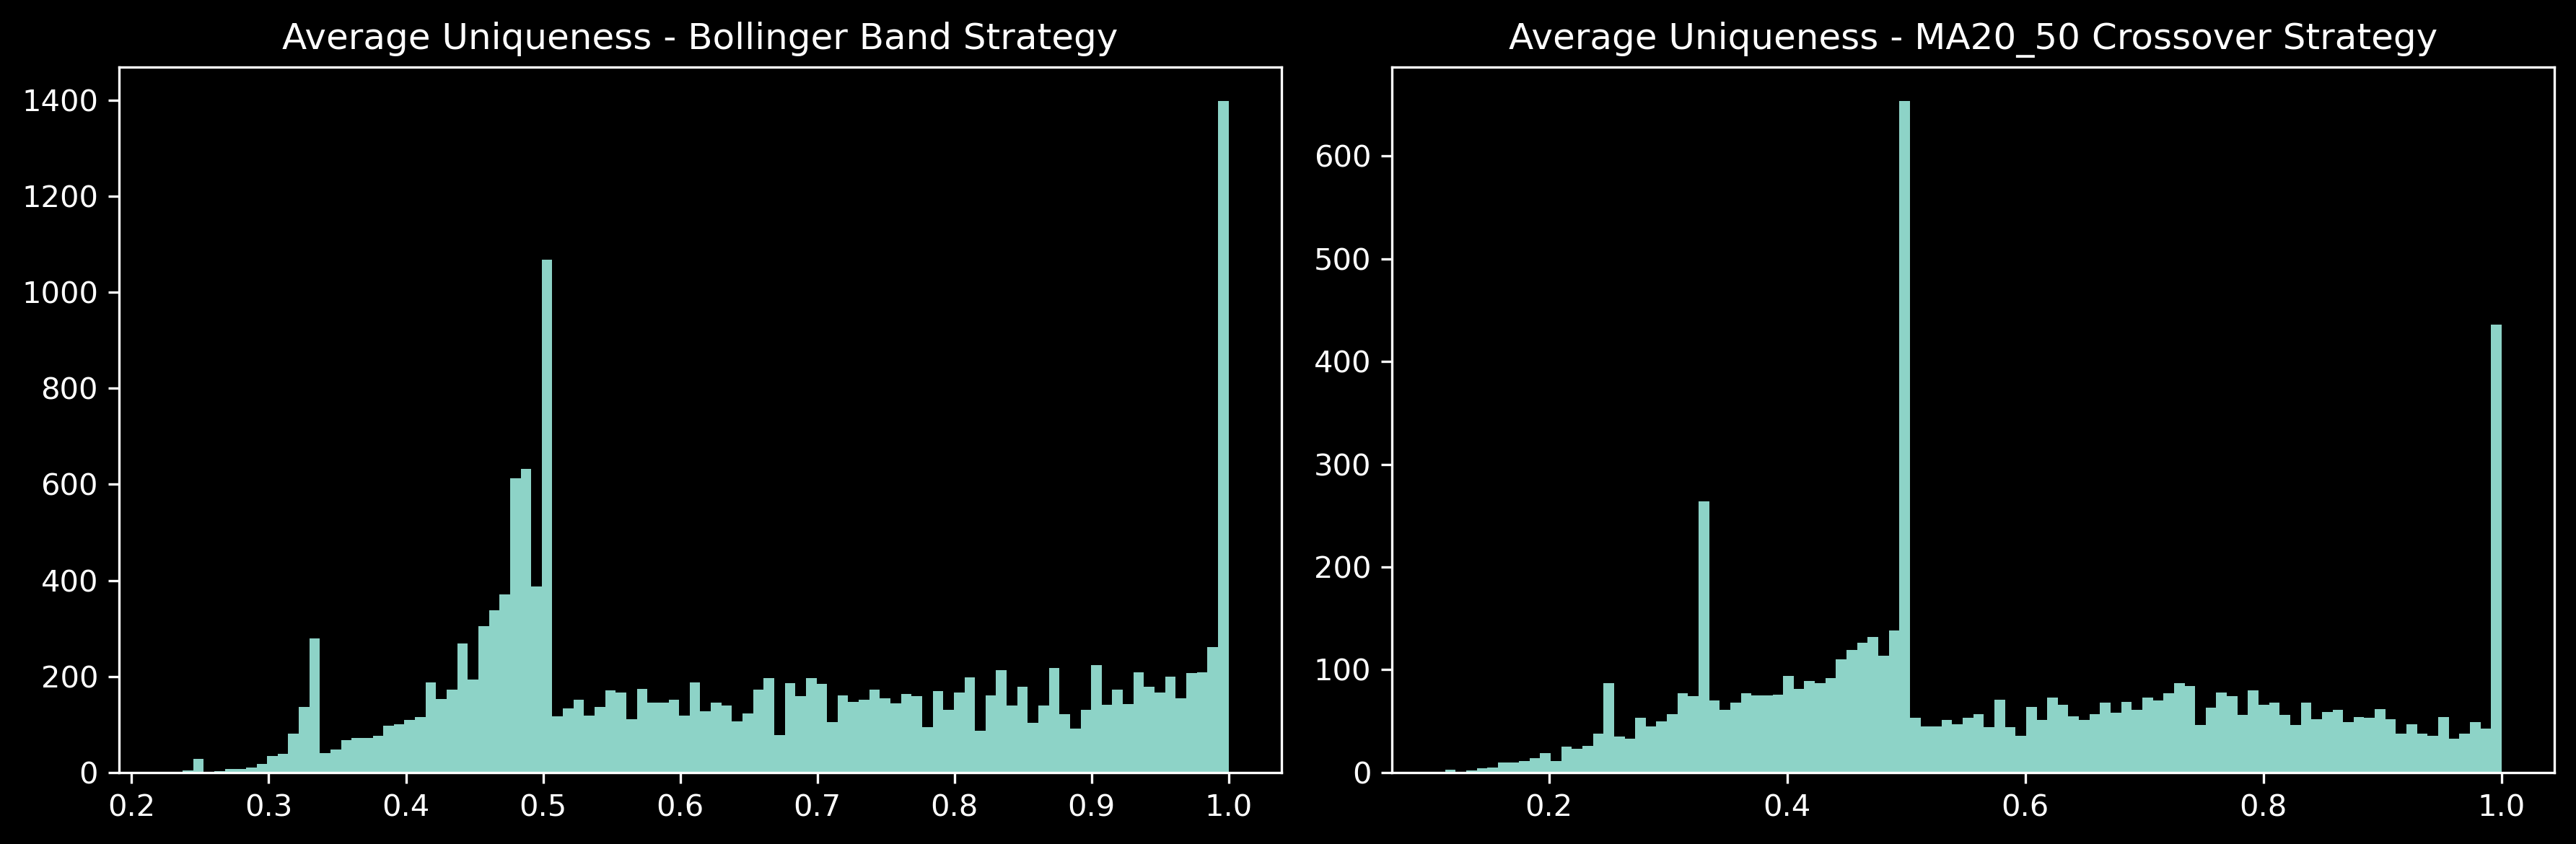

In [72]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
bins = 100
bb_events_tb_time["tW"].hist(ax=ax0, bins=bins, grid=False)
ax0.set_title("Average Uniqueness - Bollinger Band Strategy")
ma_events_tb_time["tW"].hist(ax=ax1, bins=bins, grid=False)
ax1.set_title(f"Average Uniqueness - MA{fast_window}_{slow_window} Crossover Strategy")
plt.tight_layout()
fig.savefig("average_uniqueness_comparison.png", dpi=300);



#### Trend-Scanning Method

In [ ]:
span = (5, ma_time_horizon)
volatility_threshold = 0.0
trend_events = trend_scanning_labels(close, span, volatility_threshold)
trend_events = drop_labels(trend_events)
ma_events_trend_time = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold})")
value_counts_data(ma_events_trend_time["bin"], verbose=False)

2025-10-11 22:28:15 | INFO     | Dropped label: 0 - 0.0020%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2290 entries, 2018-01-02 11:30:00 to 2021-12-30 06:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        2290 non-null   datetime64[ns]
 1   window    2290 non-null   int32         
 2   slope     2290 non-null   float64       
 3   t_value   2290 non-null   float64       
 4   rsquared  2290 non-null   float64       
 5   ret       2290 non-null   float32       
 6   bin       2290 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 109.6 KB

Trend-Scanning Labels (σ = 0.0)


,count,proportion
bin,,
-1,"1,170",0.510917
1,"1,120",0.489083


In [ ]:
volatility_threshold1 = 0.05

trend_events = trend_scanning_labels(close, span, volatility_threshold1)
trend_events = drop_labels(trend_events)
ma_events_trend_time1 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time1.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold1})")
value_counts_data(ma_events_trend_time1["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2290 entries, 2018-01-02 11:30:00 to 2021-12-30 06:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        2290 non-null   datetime64[ns]
 1   window    2290 non-null   int32         
 2   slope     2290 non-null   float64       
 3   t_value   2290 non-null   float64       
 4   rsquared  2290 non-null   float64       
 5   ret       2290 non-null   float32       
 6   bin       2290 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 109.6 KB

Trend-Scanning Labels (σ = 0.05)


,count,proportion
bin,,
-1,"1,051",0.458952
1,"1,021",0.445852
0,218,0.095197


In [ ]:
volatility_threshold2 = 0.1

trend_events = trend_scanning_labels(close, span, volatility_threshold2)
trend_events = drop_labels(trend_events)
ma_events_trend_time2 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time2.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold2})")
value_counts_data(ma_events_trend_time2["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2290 entries, 2018-01-02 11:30:00 to 2021-12-30 06:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        2290 non-null   datetime64[ns]
 1   window    2290 non-null   int32         
 2   slope     2290 non-null   float64       
 3   t_value   2290 non-null   float64       
 4   rsquared  2290 non-null   float64       
 5   ret       2290 non-null   float32       
 6   bin       2290 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 109.6 KB

Trend-Scanning Labels (σ = 0.1)


,count,proportion
bin,,
-1,952,0.415721
1,934,0.407860
0,404,0.176419


In [ ]:
volatility_threshold3 = 0.2

trend_events = trend_scanning_labels(close, span, volatility_threshold3)
trend_events = drop_labels(trend_events)
ma_events_trend_time3 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time3.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold3})")
value_counts_data(ma_events_trend_time3["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2290 entries, 2018-01-02 11:30:00 to 2021-12-30 06:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        2290 non-null   datetime64[ns]
 1   window    2290 non-null   int32         
 2   slope     2290 non-null   float64       
 3   t_value   2290 non-null   float64       
 4   rsquared  2290 non-null   float64       
 5   ret       2290 non-null   float32       
 6   bin       2290 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 109.6 KB

Trend-Scanning Labels (σ = 0.2)


,count,proportion
bin,,
1,817,0.356769
-1,792,0.345852
0,681,0.297380


In [ ]:
volatility_threshold4 = 0.3

trend_events = trend_scanning_labels(close, span, volatility_threshold4)
trend_events = drop_labels(trend_events)
ma_events_trend_time4 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_time4.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold4})")
value_counts_data(ma_events_trend_time4["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2290 entries, 2018-01-02 11:30:00 to 2021-12-30 06:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        2290 non-null   datetime64[ns]
 1   window    2290 non-null   int32         
 2   slope     2290 non-null   float64       
 3   t_value   2290 non-null   float64       
 4   rsquared  2290 non-null   float64       
 5   ret       2290 non-null   float32       
 6   bin       2290 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 109.6 KB

Trend-Scanning Labels (σ = 0.3)


,count,proportion
bin,,
0,952,0.415721
1,681,0.297380
-1,657,0.286900


In [ ]:
# # Test on distinct market regimes
# regimes = {
#     "high_volatility": "2020-03-01:2020-04-30",  # COVID crash
#     "consolidation": "2021-01-01:2021-03-31",         # Consolidation
#     "downtrend": "2022-05-01:2022-07-31"           # Steady trend
# }

# for regime_name, period in regimes.items():
#     start, end = period.split(":")
#     regime_data = ma_time_bars.loc[start : end, "close"]
#     plt.figure(figsize=(7.5, 4), dpi=100)
#     regime_data.plot(title=f"Market Regime: {regime_name}", figsize=(10, 4))
#     labels = trend_scanning_labels(regime_data, span=(5, 60), volatility_threshold=0.0)
    
#     # Plot: distribution of optimal windows per regime
#     plt.figure(figsize=(7.5, 4), dpi=100)
#     labels['window'].hist(bins=20)
#     plt.title(f"Optimal Horizon Distribution - {regime_name}")
#     plt.xlabel("Window Length")
    
#     # Show average window size and t-stat strength per regime
#     print(f"{regime_name}: Avg Window = {labels['window'].mean():.1f}, "
#           f"Avg |t-value| = {labels['t_value'].abs().mean():.2f}")

### Tick-Bars

In [ ]:
ma_df = ma_tick_bars.loc[sample_start : sample_end]
close = ma_df.close
vol_target = get_daily_vol(close, lookback=100) # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")
ma_side = ma_strategy.generate_signals(ma_df)

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(ma_timeframe) if x.isnumeric()))
ma_tick_horizon = ma_time_horizon * tm
if ma_timeframe.startswith("H"):
    ma_tick_horizon *= 60
elif ma_timeframe.startswith("D"):
    ma_tick_horizon *= 60 * 24

print(f"Time Horizon: {pd.Timedelta(minutes=tm)}")
vertical_barriers = add_vertical_barrier(t_events, close, minutes=ma_tick_horizon)

2025-10-11 22:29:55 | INFO     | 4,593 CUSUM-filtered events
CUSUM filter threshold: 0.2231%, t_events: 4,593
Time Horizon: 0 days 00:15:00


#### Feature Engineering

In [ ]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_df, timeframe=ma_timeframe)
ma_feat_tick = ma_feat.copy()
ma_feat.info()

Memory usage reduced from 76.71 MB to 40.49 MB (47.2% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122123 entries, 2018-01-02 00:06:59.282001 to 2021-12-31 22:36:04.856001
Data columns (total 94 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ma_10                           122123 non-null  float32
 1   ma_20                           122123 non-null  float32
 2   ma_50                           122123 non-null  float32
 3   ma_100                          122123 non-null  float32
 4   ma_200                          122123 non-null  float32
 5   ma_10_20_cross                  122123 non-null  float64
 6   ma_20_50_cross                  122123 non-null  float64
 7   ma_50_200_cross                 122123 non-null  float64
 8   ma_spread_10_20                 122123 non-null  float32
 9   ma_spread_20_50                 122123 non-null  float32
 10  ma_spread_50_200           

#### Triple-Barrier Method

In [ ]:
ma_events_tb = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_tb = get_event_weights(ma_events_tb, close)
ma_events_tb_tick = ma_events_tb.copy()
ma_events_tb.info()
ret = ma_events_tb.ret
sr_ma_tbl = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_tbl:.4f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4584 entries, 2018-01-03 08:12:19.476001 to 2021-12-30 15:45:33.324001
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      4584 non-null   datetime64[ns]
 1   trgt    4584 non-null   float64       
 2   ret     4584 non-null   float64       
 3   bin     4584 non-null   int8          
 4   side    4584 non-null   int8          
 5   tW      4584 non-null   float64       
 6   w       4584 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int8(2)
memory usage: 352.9 KB

Sharpe Ratio: -0.0069


#### Trend-Scanning Method

In [ ]:
volatility_threshold = 0.0

trend_events = trend_scanning_labels(close, span, volatility_threshold)
trend_events = drop_labels(trend_events)
ma_events_trend_tick = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_tick.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold})")
value_counts_data(ma_events_trend_tick["bin"], verbose=False)

2025-10-11 22:33:59 | INFO     | Dropped label: 0 - 0.0025%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4583 entries, 2018-01-02 08:47:09.144001 to 2021-12-29 15:31:17.104001
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        4583 non-null   datetime64[ns]
 1   window    4583 non-null   int32         
 2   slope     4583 non-null   float64       
 3   t_value   4583 non-null   float64       
 4   rsquared  4583 non-null   float64       
 5   ret       4583 non-null   float32       
 6   bin       4583 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 219.3 KB

Trend-Scanning Labels (σ = 0.0)


,count,proportion
bin,,
1,"2,314",0.504909
-1,"2,269",0.495091


In [ ]:
volatility_threshold1 = 0.05

trend_events = trend_scanning_labels(close, span, volatility_threshold1)
trend_events = drop_labels(trend_events)
ma_events_trend_tick1 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_tick1.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold1})")
value_counts_data(ma_events_trend_tick1["bin"], verbose=False)

2025-10-11 22:34:09 | INFO     | Dropped label: 0 - 4.2075%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4403 entries, 2018-01-02 08:47:09.144001 to 2021-12-29 15:31:17.104001
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        4403 non-null   datetime64[ns]
 1   window    4403 non-null   int32         
 2   slope     4403 non-null   float64       
 3   t_value   4403 non-null   float64       
 4   rsquared  4403 non-null   float64       
 5   ret       4403 non-null   float32       
 6   bin       4403 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 210.7 KB

Trend-Scanning Labels (σ = 0.05)


,count,proportion
bin,,
1,"2,230",0.506473
-1,"2,173",0.493527


In [ ]:
volatility_threshold2 = 0.1

trend_events = trend_scanning_labels(close, span, volatility_threshold2)
trend_events = drop_labels(trend_events)
ma_events_trend_tick2 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_tick2.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold2})")
value_counts_data(ma_events_trend_tick2["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4583 entries, 2018-01-02 08:47:09.144001 to 2021-12-29 15:31:17.104001
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        4583 non-null   datetime64[ns]
 1   window    4583 non-null   int32         
 2   slope     4583 non-null   float64       
 3   t_value   4583 non-null   float64       
 4   rsquared  4583 non-null   float64       
 5   ret       4583 non-null   float32       
 6   bin       4583 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 219.3 KB

Trend-Scanning Labels (σ = 0.1)


,count,proportion
bin,,
1,"2,129",0.464543
-1,"2,068",0.451233
0,386,0.084224


In [ ]:
volatility_threshold3 = 0.2

trend_events = trend_scanning_labels(close, span, volatility_threshold3)
trend_events = drop_labels(trend_events)
ma_events_trend_tick3 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_tick3.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold3})")
value_counts_data(ma_events_trend_tick3["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4583 entries, 2018-01-02 08:47:09.144001 to 2021-12-29 15:31:17.104001
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        4583 non-null   datetime64[ns]
 1   window    4583 non-null   int32         
 2   slope     4583 non-null   float64       
 3   t_value   4583 non-null   float64       
 4   rsquared  4583 non-null   float64       
 5   ret       4583 non-null   float32       
 6   bin       4583 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 219.3 KB

Trend-Scanning Labels (σ = 0.2)


,count,proportion
bin,,
1,"1,967",0.429195
-1,"1,878",0.409775
0,738,0.161030


In [ ]:
volatility_threshold4 = 0.3

trend_events = trend_scanning_labels(close, span, volatility_threshold4)
trend_events = drop_labels(trend_events)
ma_events_trend_tick4 = trend_events.reindex(t_events.intersection(trend_events.index))
ma_events_trend_tick4.info()

print(f"\nTrend-Scanning Labels (σ = {volatility_threshold4})")
value_counts_data(ma_events_trend_tick4["bin"], verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4583 entries, 2018-01-02 08:47:09.144001 to 2021-12-29 15:31:17.104001
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   t1        4583 non-null   datetime64[ns]
 1   window    4583 non-null   int32         
 2   slope     4583 non-null   float64       
 3   t_value   4583 non-null   float64       
 4   rsquared  4583 non-null   float64       
 5   ret       4583 non-null   float32       
 6   bin       4583 non-null   int8          
dtypes: datetime64[ns](1), float32(1), float64(3), int32(1), int8(1)
memory usage: 219.3 KB

Trend-Scanning Labels (σ = 0.3)


,count,proportion
bin,,
1,"1,772",0.386646
-1,"1,697",0.370281
0,"1,114",0.243072


### Random Forest

In [ ]:
dashes = "-" * 60

plot_titles = [
    f"Fixed-Time Horizon (h = {ma_time_horizon})", 
    f"Triple-Barrier (pt = {ma_pt_barrier}, sl = {ma_sl_barrier}, h = {ma_time_horizon})", 
    fr"Trend-Scanning ($\sigma = {volatility_threshold}$)",
    ]
ma_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    ]

name = ma_strategy.get_strategy_name()
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    ]
print(f"Strategy: {ma_strategy.get_strategy_name()}")

random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Strategy: MACrossover_20_50


##### Time-Bars

2025-10-11 22:36:09 | INFO     | Samples are equally weighted.
2025-10-11 22:36:09 | INFO     | Training on 1,602 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       471
           1       0.31      1.00      0.48       216

    accuracy                           0.31       687
   macro avg       0.16      0.50      0.24       687
weighted avg       0.10      0.31      0.15       687


Confusion Matrix:
[[  0 471]
 [  0 216]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.55      0.62       471
           1       0.34      0.50      0.40       216

    accuracy              

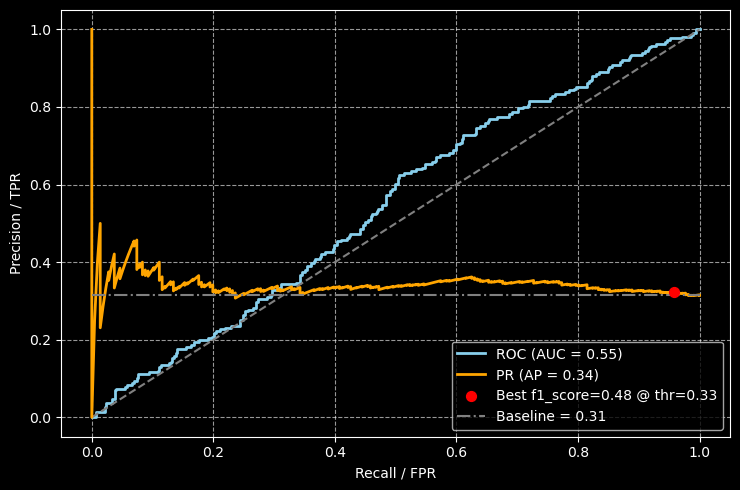

In [ ]:
model_ma_tb_time = train_model(model=rf, X=ma_feat_time, events=ma_events_tb_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_tb_time, plot=True)

In [ ]:
model_ma_trend_time = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time)

model_ma_trend_time_w = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w)

Reloading 'afml.backtester.training'.
2025-10-11 22:37:46 | INFO     | Samples are equally weighted.
2025-10-11 22:37:46 | INFO     | Training on 1,604 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.0) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.50      0.75      0.60       357
           1       0.41      0.19      0.26       329

    accuracy                           0.48       686
   macro avg       0.46      0.47      0.43       686
weighted avg       0.46      0.48      0.44       686


Confusion Matrix:
[[268  89]
 [266  63]]
2025-10-11 22:37:55 | INFO     | Samples weighted by t_value.
2025-10-11 22:37:55 | INFO     | Training on 1,604 samples...

------------------------------------------------------------
TREND-SCANNING (σ = 0.0) T-VALUE WEIGHTED E

In [ ]:
model_ma_trend_time1 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time1)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold1}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time1)

model_ma_trend_time_w1 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time1, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold1}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w1)

2025-10-11 22:38:03 | INFO     | Samples are equally weighted.
2025-10-11 22:38:03 | INFO     | Training on 1,604 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.05) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.51      0.58      0.54       334
           0       0.16      0.53      0.24        38
           1       0.51      0.28      0.36       314

    accuracy                           0.44       686
   macro avg       0.39      0.46      0.38       686
weighted avg       0.49      0.44      0.44       686


Confusion Matrix:
[[194  54  86]
 [ 18  20   0]
 [172  53  89]]
2025-10-11 22:38:11 | INFO     | Samples weighted by t_value.
2025-10-11 22:38:11 | INFO     | Training on 1,604 samples...

------------------------------------------------------------
TRE

In [ ]:
model_ma_trend_time2 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time2)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold2}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time2)

model_ma_trend_time_w2 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time2, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold2}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w2)

2025-10-11 22:38:20 | INFO     | Samples are equally weighted.
2025-10-11 22:38:20 | INFO     | Training on 1,604 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.1) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.49      0.46      0.48       310
           0       0.26      0.75      0.39        84
           1       0.48      0.26      0.33       292

    accuracy                           0.41       686
   macro avg       0.41      0.49      0.40       686
weighted avg       0.46      0.41      0.41       686


Confusion Matrix:
[[144  93  73]
 [ 13  63   8]
 [134  83  75]]
2025-10-11 22:38:28 | INFO     | Samples weighted by t_value.
2025-10-11 22:38:28 | INFO     | Training on 1,604 samples...

------------------------------------------------------------
TREN

In [ ]:
model_ma_trend_time3 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time3)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold3}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time3)

model_ma_trend_time_w3 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time3, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold3}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w3)

2025-10-11 22:38:36 | INFO     | Samples are equally weighted.
2025-10-11 22:38:37 | INFO     | Training on 1,604 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.2) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.39      0.53      0.45       239
           0       0.53      0.68      0.60       203
           1       0.35      0.15      0.21       244

    accuracy                           0.44       686
   macro avg       0.42      0.45      0.42       686
weighted avg       0.42      0.44      0.41       686


Confusion Matrix:
[[126  60  53]
 [ 48 138  17]
 [145  62  37]]
2025-10-11 22:38:47 | INFO     | Samples weighted by t_value.
2025-10-11 22:38:47 | INFO     | Training on 1,604 samples...

------------------------------------------------------------
TREN

In [ ]:
model_ma_trend_time4 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time4)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold4}) EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time4)

model_ma_trend_time_w4 = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_time4, weighting="t_value")
print(f"\n{dashes}\nTREND-SCANNING (σ = {volatility_threshold4}) T-VALUE WEIGHTED EVALUATION REPORT\n{dashes}")
labeling_reports(model_ma_trend_time_w4)

2025-10-11 22:38:54 | INFO     | Samples are equally weighted.
2025-10-11 22:38:54 | INFO     | Training on 1,604 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.3) EVALUATION REPORT
------------------------------------------------------------

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.35      0.51      0.41       185
           0       0.66      0.74      0.69       308
           1       0.30      0.11      0.16       193

    accuracy                           0.50       686
   macro avg       0.43      0.45      0.42       686
weighted avg       0.47      0.50      0.47       686


Confusion Matrix:
[[ 94  56  35]
 [ 66 227  15]
 [109  63  21]]
2025-10-11 22:39:03 | INFO     | Samples weighted by t_value.
2025-10-11 22:39:03 | INFO     | Training on 1,604 samples...

------------------------------------------------------------
TREN

In [ ]:
ma_trends = [model_ma_trend_time, model_ma_trend_time1, 
             model_ma_trend_time2, model_ma_trend_time3, model_ma_trend_time4]
trend_events = [ma_events_trend_time, ma_events_trend_time1, ma_events_trend_time2, ma_events_trend_time3, ma_events_trend_time4]

ma_vol_thresholds = [volatility_threshold, volatility_threshold1, volatility_threshold2,
                     volatility_threshold3, volatility_threshold4]

ma_trend_meta_models = {}

In [ ]:
for events, vol in zip(trend_events, ma_vol_thresholds):
    print(f"\n{dashes}\nTREND-SCANNING (σ = {vol}) EVALUATION REPORT\n{dashes}")
    t_events = ma_events_tb_time.index.intersection(events.index)
    events = events.reindex(t_events)
    tb_events = ma_events_tb_time.reindex(t_events)
    # value_counts_data(tb_events["bin"], verbose=True)
    tb_events["bin"] *= ((events["bin"] != 0) | (events["bin"] == ma_side.loc[tb_events.index]))
    # value_counts_data(tb_events["bin"], verbose=True)
    model = train_model(model=rf, X=ma_feat_time, events=tb_events)
    ma_trend_meta_models[vol] = model
    labeling_reports(model)
    


------------------------------------------------------------
TREND-SCANNING (σ = 0.0) EVALUATION REPORT
------------------------------------------------------------
2025-10-11 22:46:15 | INFO     | Samples are equally weighted.
2025-10-11 22:46:15 | INFO     | Training on 1,601 samples...

MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.52      0.59       452
           1       0.35      0.49      0.40       234

    accuracy                           0.51       686
   macro avg       0.51      0.51      0.50       686
weighted avg       0.56      0.51      0.52       686


Confusion Matrix:
[[237 215]
 [120 114]]

------------------------------------------------------------
TREND-SCANNING (σ = 0.05) EVALUATION REPORT
------------------------------------------------------------
2025-10-11 22:46:26 | INFO     | Samples are equally weighted.
2025-10-11 22:46:26 | INFO     | Tra

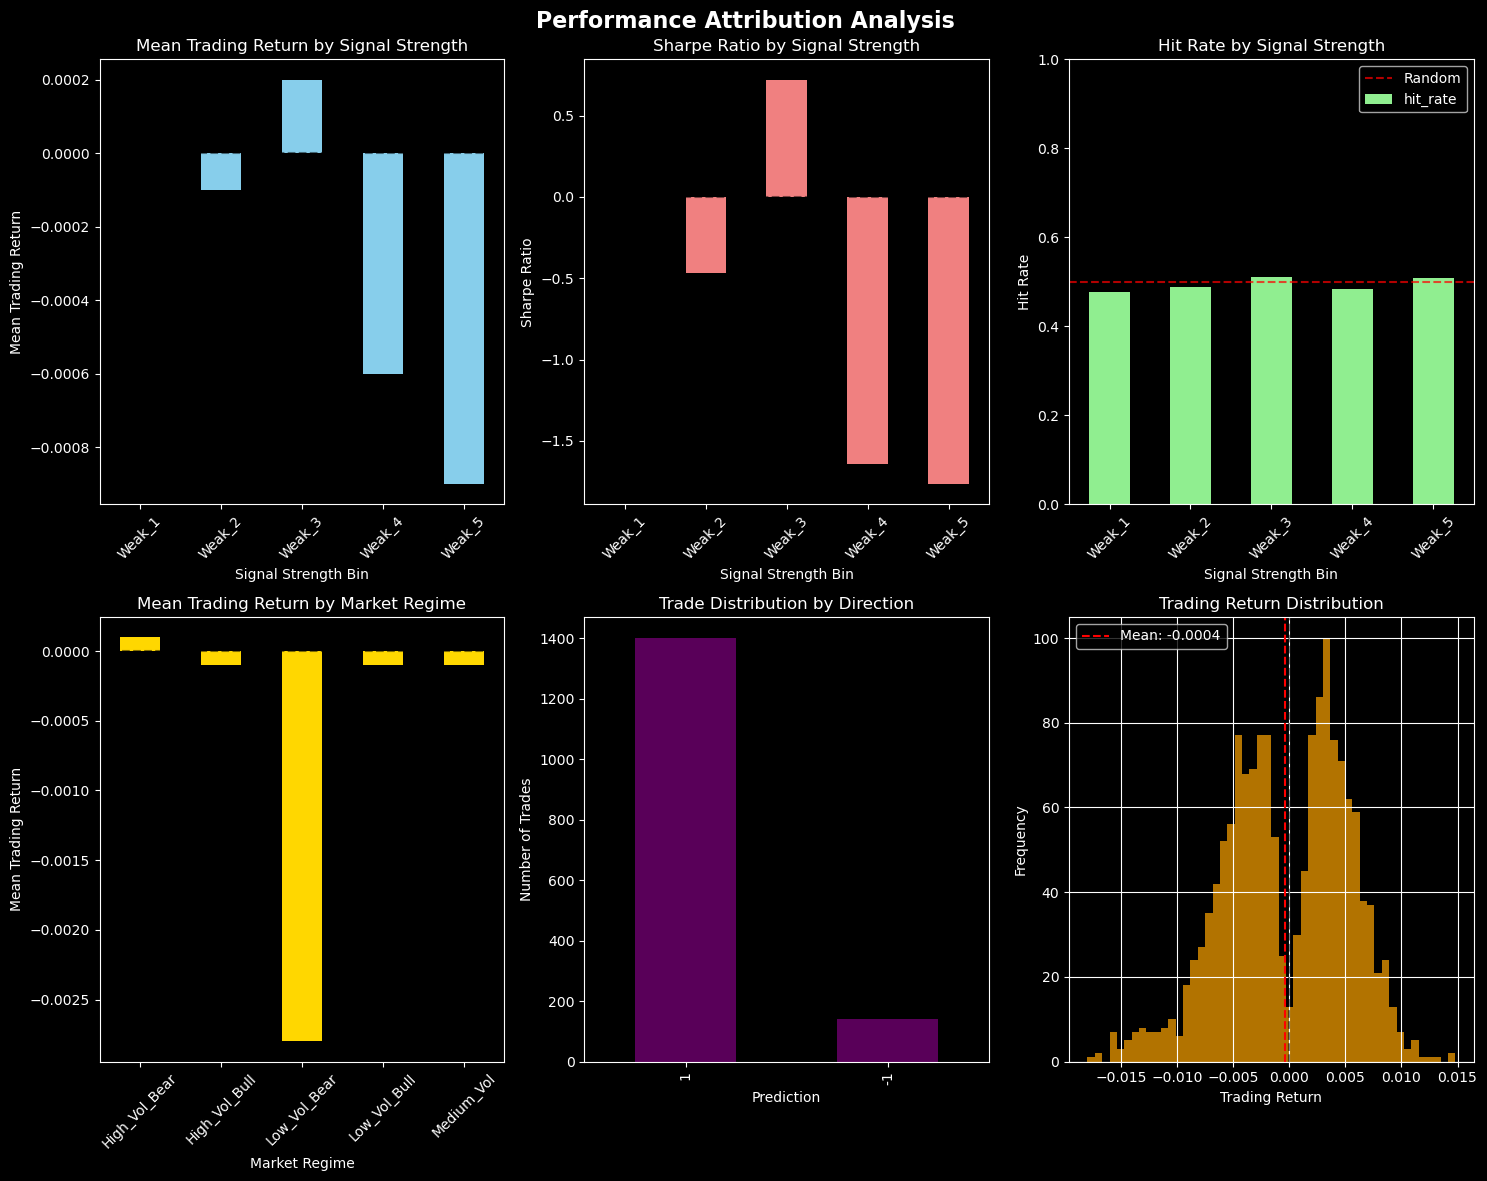

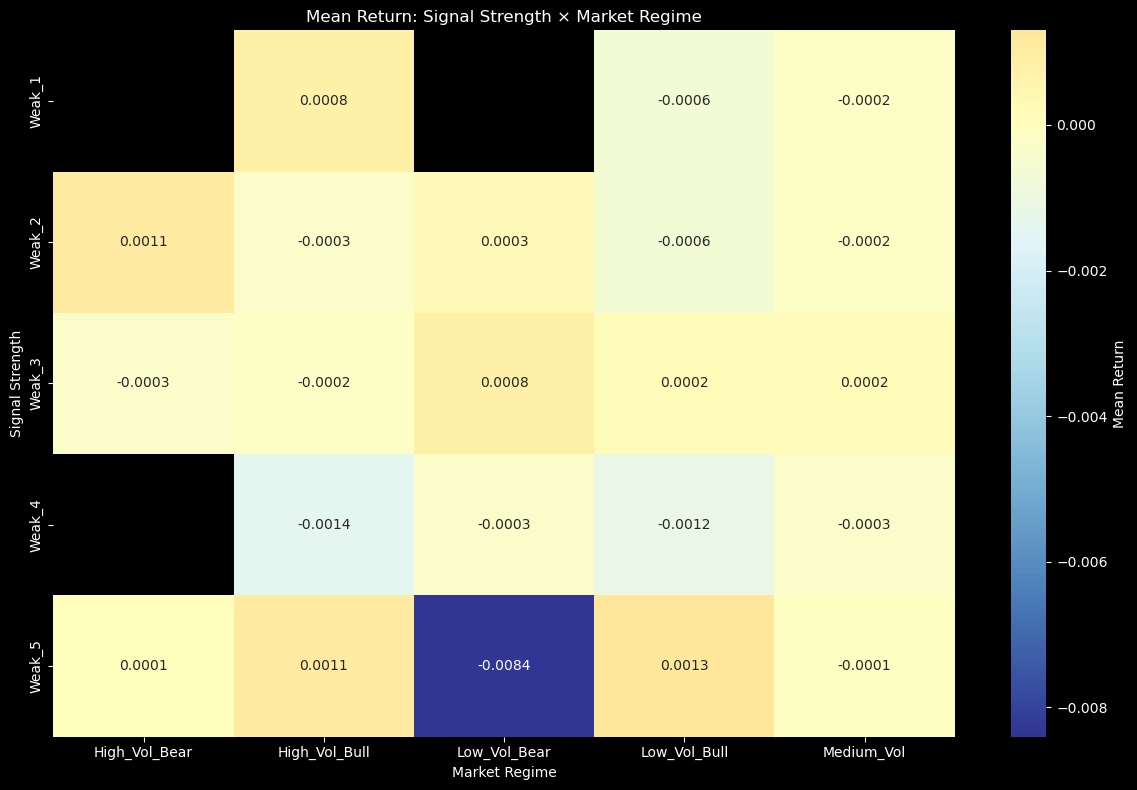

Signal Strength Analysis:
                     trading_return_count  trading_return_mean  \
signal_strength_bin                                              
Weak_1                                187              -0.0000   
Weak_2                                338              -0.0001   
Weak_3                                319               0.0002   
Weak_4                                341              -0.0006   
Weak_5                                358              -0.0009   

                     trading_return_std  trading_return_sum  abs_return_mean  \
signal_strength_bin                                                            
Weak_1                           0.0029             -0.0085           0.0023   
Weak_2                           0.0034             -0.0465           0.0030   
Weak_3                           0.0044              0.0533           0.0040   
Weak_4                           0.0058             -0.2171           0.0053   
Weak_5                         

In [ ]:
from performance_attribution import performance_attribution_analysis

# predictions = model_ma_trend_time.fit.predict(ma_feat_time.loc[:sample_end])  # Optional
# predictions = pd.Series(predictions, index=ma_feat_time.loc[:sample_end].index)
model = model_ma_trend_time2
events = model.events
predictions = model.pred  # Optional
returns = ma_df.close.pct_change().reindex(events.index)  # Daily returns aligned with features

results = performance_attribution_analysis(
    labels_df=events,  # DataFrame with at least 'bin' and 'ret' columns
    returns=returns,
    predictions=predictions,  # Optional - if None, uses labels_df['bin']
    signal_strength_bins=5,   # or [0, 1, 2, 3, 5, 10] for custom bins
    regime_lookback=252,      # 1 year for market regime classification
    plot_results=True
)

# Access results
print("Signal Strength Analysis:")
pprint(results['signal_strength_analysis'], sort_dicts=False)

print("\nMarket Regime Analysis:")
pprint(results['market_regime_analysis'], sort_dicts=False)

print("\nSummary Stats:")
for key, value in results['summary_stats'].items():
    print(f"{key}: {value:.4f}")

###### Return-Weighted

In [ ]:
model_ma_fh_time_w = train_model(model=rf, X=ma_feat_time, events=ma_events_fh_time, weighting="return")
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_fh_time_w, plot=True)

In [ ]:
model_ma_tb_time_w = train_model(model=rf, X=ma_feat_time, events=ma_events_tb_time, weighting="return")
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_tb_time_w, plot=True)

2025-09-22 20:08:48 | INFO     | Samples weighted by t_value.
2025-09-22 20:08:48 | INFO     | Training on 4,181 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.3) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1226
           1       0.32      1.00      0.48       565

    accuracy                           0.32      1791
   macro avg       0.16      0.50      0.24      1791
weighted avg       0.10      0.32      0.15      1791


Confusion Matrix:
[[   0 1226]
 [   0  565]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1226
           1       0.32      1.00      0.48       565

    accuracy 

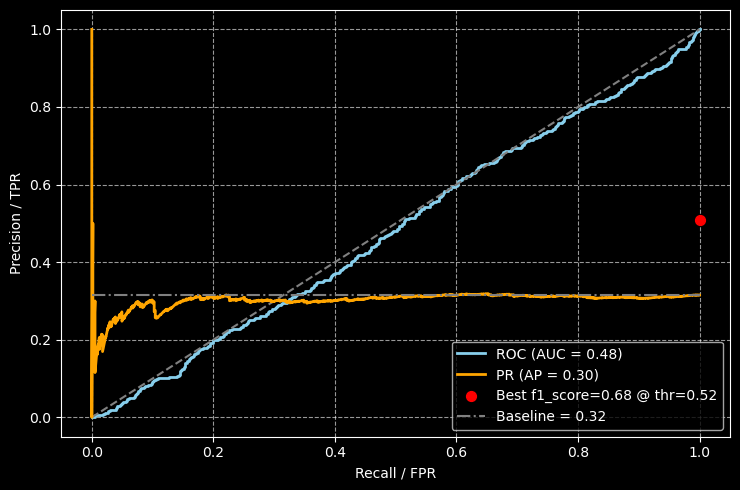

In [ ]:
model_ma_trend_time_w = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_tb_time, weighting="t_value")
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_trend_time_w, plot=True)

###### Time-Decay Weighted

In [ ]:
model_ma_fh_time_tw = train_model(model=rf, X=ma_feat_time, events=ma_events_fh_time, weighting="time", time_decay=time_decay)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_fh_time_tw, plot=True)

In [ ]:
model_ma_tb_time_tw = train_model(model=rf, X=ma_feat_time, events=ma_events_tb_time, weighting="time", time_decay=time_decay)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_tb_time_tw, plot=True)

In [ ]:
model_ma_trend_time_tw = train_model(model=rf, X=ma_feat_time, events=ma_events_trend_tb_time, weighting="time", time_decay=time_decay)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labeling_reports(model_ma_trend_time_tw, plot=True)

##### Reports

In [ ]:
dirpath = Path("reports", "time_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_time_horizon})", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon})", 
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    ]
ma_models = [model_ma_fh_time, model_ma_tb_time] 
ma_trends = [model_ma_trend_time, model_ma_trend_time1, 
             model_ma_trend_time2, model_ma_trend_time3, model_ma_trend_time4]
ma_vol_thresholds = [volatility_threshold, volatility_threshold1, volatility_threshold2,
                     volatility_threshold3, volatility_threshold4]
# ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
# ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

# ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
# ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labeling_classification_report_tables(
    model_data=ma_trends, 
    methods=ma_vol_thresholds, 
    title=f"{ma_strategy.get_strategy_name()}"
    )

0.0 accuracy: 0.500
0.05 accuracy: 0.387
0.1 accuracy: 0.407
0.2 accuracy: 0.482
0.3 accuracy: 0.550
2025-09-27 01:51:22 | INFO     | Saved to ..\reports\MACrossover_20_50_classification_comparison.html

                      0.0     0.05      0.1      0.2      0.3
class                                                        
-1    precision     0.505    0.489    0.486    0.448    0.428
      recall        0.545    0.382    0.408    0.440    0.413
      f1-score      0.524    0.429    0.444    0.444    0.420
      support    1043.000  985.000  909.000  752.000  622.000
0     precision       NaN    0.176    0.297    0.525    0.658
      recall          NaN    1.000    0.926    0.875    0.858
      f1-score        NaN    0.299    0.449    0.656    0.745
      support         NaN  115.000  256.000  566.000  840.000
1     precision     0.495    0.479    0.464    0.444    0.425
      recall        0.455    0.319    0.259    0.228    0.260
      f1-score      0.474    0.383    0.332    0.301

In [ ]:
ma_trends_w = [model_ma_trend_time_w, model_ma_trend_time_w1, model_ma_trend_time_w2, 
               model_ma_trend_time_w3, model_ma_trend_time_w4]
meta_labeling_classification_report_tables(
    model_data=ma_trends_w, 
    methods=ma_vol_thresholds, 
    title=f"{ma_strategy.get_strategy_name()}_weighted"
    )

0.0 accuracy: 0.509
0.05 accuracy: 0.514
0.1 accuracy: 0.508
0.2 accuracy: 0.501
0.3 accuracy: 0.488
2025-09-27 02:04:44 | INFO     | Saved to ..\reports\MACrossover_20_50_weighted_classification_comparison.html

                      0.0     0.05      0.1      0.2      0.3
class                                                        
-1    precision     0.514    0.514    0.509    0.502    0.490
      recall        0.513    0.585    0.538    0.516    0.468
      f1-score      0.513    0.548    0.523    0.509    0.479
      support    1043.000  945.000  865.000  721.000  596.000
1     precision     0.504    0.513    0.506    0.501    0.485
      recall        0.505    0.442    0.478    0.487    0.508
      f1-score      0.504    0.475    0.492    0.494    0.496
      support    1022.000  935.000  858.000  719.000  589.000


In [ ]:
meta_labeling_classification_report_tables(
    model_data=ma_models, 
    methods=["fixed_horizon", "triple_barrier"],
    title=f"{ma_strategy.get_strategy_name()}_weighted"
    )

fixed_horizon accuracy: 0.489
triple_barrier accuracy: 0.552
2025-09-26 03:52:06 | INFO     | Saved to ..\reports\MACrossover_20_50_weighted_classification_comparison.html

                 fixed_horizon  triple_barrier
class                                         
0     precision          0.509           0.712
      recall             0.410           0.550
      f1-score           0.454           0.620
      support         1070.000        1373.000
1     precision          0.474           0.383
      recall             0.573           0.557
      f1-score           0.519           0.454
      support          993.000         690.000


##### Out-of-Sample

In [ ]:
# Create events set for model
df = ma_time_bars[sample_end:]
close = df.close.copy()
target = get_daily_vol(ma_time_bars.close, vol_lookback).reindex(df.index) * ma_vol_multiplier

side, t_events = get_entries(ma_strategy, df, on_crossover=1)
vertical_barrier_times = add_vertical_barrier(t_events, close, num_bars=ma_time_horizon)

# Create feature set for model
X_test = ma_feat_time.reindex(t_events).dropna().copy()
# value_counts_data(X_test.side, verbose=True)
# X_test.info()

ma_events_fh_time_oos = get_events(
    close, t_events, 
    pt_sl=[0, 0],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=ma_side,
    )

ma_events_tb_time_oos = get_events(
    close, t_events, 
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    target=target, 
    vertical_barrier_times=vertical_barrier_times, 
    side_prediction=ma_side,
    )
ma_events_trend_time_oos = ma_events_tb_time_oos.copy()
# ma_events_trend_time_oos = get_events(
#     close, t_events, 
#     pt_sl=[ma_pt_barrier, ma_sl_barrier],
#     target=target, 
#     vertical_barrier_times=None, 
#     side_prediction=ma_side,
#     )

labeling_methods = [
    "fixed_horizon", 
    "triple_barrier", 
    "trend_scanning", 
    ]

i = 1  # Choose which trend model to use (0-4)
trend_model = ma_trends_w[i]
key = list(ma_trend_meta_models.keys())[i]
ts_pred = trend_model.fit.predict(X_test)

value_counts_data(ma_events_trend_time_oos["side"], verbose=True)
ts_side = ma_events_trend_time_oos["side"]
ma_events_trend_time_oos["side"] *= (ts_pred == ts_side)
value_counts_data(ma_events_trend_time_oos["side"], verbose=True)
# ma_events_trend_time_oos = ma_events_trend_time_oos[ma_events_trend_time_oos["side"] != 0].dropna(subset=["t1"])


models = [model_ma_fh_time, model_ma_tb_time, ma_trend_meta_models[key]]
events_oos = {"fixed_horizon": ma_events_fh_time_oos, 
              "triple_barrier": ma_events_tb_time_oos,
              "trend_scanning": ma_events_trend_time_oos,
              }
print(f"Out-of-Sample Events TB: {ma_events_tb_time_oos.shape}")
print(f"Out-of-Sample Events TS: {ma_events_trend_time_oos.shape}")

2025-09-27 02:33:28 | INFO     | MACrossover_20_50 | 5,026 (2.27%) trade events generated from crossovers.

      count  proportion
side                   
-1    2,513         0.5
 1    2,513         0.5


      count  proportion
side                   
0     3,661    0.728412
1     1,365    0.271588

Out-of-Sample Events TB: (5026, 5)
Out-of-Sample Events TS: (5026, 5)


In [ ]:
bet_sizing_methods = [None, 'probability', 'budget', 'reserve', 'dynamic']
bet_sizing = bet_sizing_methods[0]

if bet_sizing == "probability":
    bet_sizing_args = dict(step_size=0.1, average_active=1)
else:
    bet_sizing_args = dict()

ma_model_results_time = {}
time_metrics_oos = {"primary_model": {}, "meta_model": {}}
ma_metrics_time = pd.DataFrame()

In [ ]:
n = len(labeling_methods)
i, j = 0, n
for model_name, model in zip(labeling_methods[i : j], models[i : j]):
    events = events_oos[model_name]
    prob = pd.Series(model.fit.predict_proba(X_test)[:, 1], index=X_test.index)
    name = f"{ma_strategy.get_strategy_name()} — {model_name.replace('_', ' ').title()} Labels"
    results = run_meta_labeling_analysis(
        events,
        meta_probabilities=prob,
        close=close,
        confidence_threshold=0.5,
        strategy_name=name,
        bet_sizing=bet_sizing,
        # save_path=f"..reports/{ma_strategy.get_strategy_name()}_{model_name}.txt",
        **bet_sizing_args
        )
    ma_model_results_time[model_name] = results
    ma_metrics_time[model_name] = results["meta_metrics"]

ma_metrics_time

2025-09-27 02:37:04 | INFO     | Bet Sizing Method: None | Confidence Threshold: 0.5

Meta-Labeling Performance Analysis: MACrossover_20_50 — Fixed Horizon Labels

Signal Filtering Summary:
  Total Primary Signals: 5,024
  Filtered Signals: 2,665
  Filter Rate: 46.95%
  Confidence Threshold: 0.5

CORE PERFORMANCE METRICS       Primary         Meta-Labeled    Improvement    
Total Return                   -6.63%          -12.49%         -88.4%         
Annualized Return              -2.26%          -4.35%          -92.4%         
Sharpe Ratio                   -0.8093         -3.7228         -360.0%        
Sortino Ratio                  -1.1222         -5.0928         -353.8%        
Calmar Ratio                   -0.2329         -0.2849         -22.3%         

RISK METRICS                   Primary         Meta-Labeled    Improvement    
Max Drawdown                   9.70%           15.27%          -57.4%         
Avg Drawdown                   1.47%           2.19%           -48.6%

,fixed_horizon,triple_barrier,trend_scanning
total_return,-0.124942,-0.050359,0.045288
annualized_return,-0.043504,-0.017072,0.01487
volatility,0.888104,0.709836,0.521126
downside_volatility,0.649197,0.323178,0.32075
sharpe_ratio,-3.722773,-1.66439,2.616468
sortino_ratio,-5.092763,-3.655701,4.251009
var_95,-0.005302,-0.003206,-0.002467
cvar_95,-0.007848,-0.004445,-0.003576
skewness,-0.107052,1.311478,2.165464
kurtosis,3.459559,4.599455,14.055488


In [ ]:
# pd.DataFrame.from_dict(ma_model_results_time["fixed_horizon"]["primary_metrics"], orient="index", columns=["primary_model"])
# pd.DataFrame.from_dict(ma_model_results_time["triple_barrier"]["primary_metrics"], orient="index", columns=["primary_model"])
# pd.DataFrame.from_dict(ma_model_results_time["trend_scanning"]["primary_metrics"], orient="index", columns=["primary_model"])

,primary_model
total_return,0.045288
annualized_return,0.01487
volatility,0.37952
downside_volatility,0.32075
sharpe_ratio,1.905772
sortino_ratio,2.254964
var_95,-0.001856
cvar_95,-0.002901
skewness,2.991645
kurtosis,29.223876


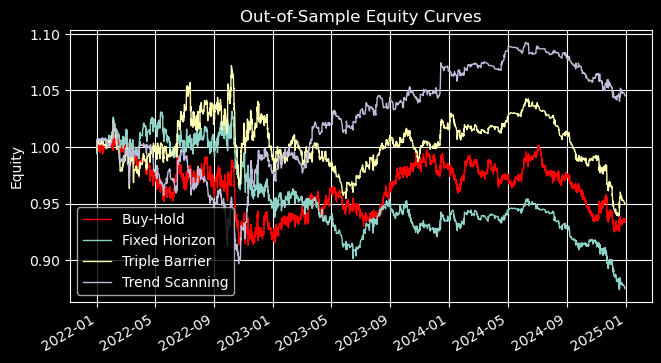

In [ ]:
# pret = ma_model_results_time[labeling_methods[0]]['primary_returns']
# plt.Figure(figsize=(7.5, 4), dpi=100)

for i in range(len(labeling_methods)):
    method = labeling_methods[i]
    if i == 0:
        (1 + ma_model_results_time[method]['primary_returns']).cumprod().plot(label="Buy-Hold ", linewidth=1, color='red')

    mret = ma_model_results_time[method]['meta_returns']
    # (1 + pret).cumprod().plot(label="Primary Model")
    (1 + mret).cumprod().plot(label=f"{method.replace('_', ' ').title()}", linewidth=1, figsize=(7.5, 4))

plt.title(f"Out-of-Sample Equity Curves")
plt.legend()
plt.grid()
plt.xlabel('')
plt.ylabel('Equity');

In [ ]:
ma_model_results_time[labeling_methods[0]].keys()

dict_keys(['strategy_name', 'primary_metrics', 'meta_metrics', 'primary_returns', 'meta_returns', 'total_primary_signals', 'filtered_signals'])

##### Tick-Bars

In [ ]:
model_ma_fh_tick = train_model(model=rf, features=ma_feat_tick, events=ma_events_fh_tick)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_ma_fh_tick, plot=True)

In [ ]:
model_ma_tbl_tick = train_model(model=rf, features=ma_feat_tick, events=ma_events_tb_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_ma_tbl_tick, plot=True)

In [ ]:
model_ma_trend_tick = train_model(model=rf, features=ma_feat_tick, events=ma_events_trend_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_ma_trend_tick, plot=True)

In [ ]:
model_ma_trend_mr_tick = train_model(model=rf, features=ma_feat_tick, events=ma_events_trend_mr_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
summary = meta_labeling_reports(model_ma_trend_mr_tick, plot=True)

In [ ]:
dirpath = Path("reports", "tick_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_tick_horizon} minutes)", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_tick_horizon})", 
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    fr"Trend-Scanning ($\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh_tick, model_ma_tbl_tick, model_ma_trend_tick, model_ma_trend_mr_tick]
ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labeling_classification_report_tables(model_data=ma_models, title=bb_titles, output_filename=dirpath / "ma_fixed_tick")

## Measurements Section for Article

- **Precision**: Precision is the fraction of true positives among the predicted
positives,
$$precision = TP / (TP + FP)$$
    
- **Recall**: Recall is the fraction of true positives among the positives,
$$recall = TP / (TP + FN)$$

- **F1**: Accuracy may not be an adequate classification score for meta-labeling applications. Suppose that, after you apply meta-labeling, there are many more negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a classifier that predicts every case to be negative will achieve high 'accuracy' or 'neg_log_loss', even though it has not learned from the features how to discriminate between cases. In fact, such a model achieves zero recall and undefined precision. The 'f1' score corrects for that performance inflation by scoring the classifier in terms of precision and recall,
$$F1 = 2(precision * recall) / (precision + recall)$$

As a side note, consider the unusual scenario where, after applying meta-labeling, there are many more positive cases than negative cases. A classifier that predicts all cases to be positive will achieve TN=0 and FN=0, hence accuracy=precision and recall=1. Accuracy will be high, and F1 will not be smaller than accuracy, even though the classifier is not able to discriminate between the observed samples. One solution would be to switch the definitions of positive and negative cases, so that negative cases are predominant, and then score with F1.


Table 14.1 characterizes the four degenerate cases of binary classification.
As you can see, the F1 score is not defined in two of those cases. For this reason, when Scikit-learn is asked to compute F1 on a sample with no observed 1s or with no predicted 1s, it will print a warning (```UndefinedMetricWarning```), and set the F1 value to 0.

TABLE 14.1 The Four Degenerate Cases of Binary Classification

| Condition | Collapse | Accuracy | Precision | Recall | F1 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Observed all 1s | TN=FP=0 | =recall | 1 | [0,1] | [0,1] |
| Observed all 0s | TP=FN=0 | [0,1] | 0 | NaN | NaN |
| Predicted all 1s | TN=FN=0 | =precision  |[0,1] | 1 | [0,1] |
| Predicted all 0s | TP=FP=0 | [0,1] | NaN | 0 | NaN |

When all observed values are positive (label ‘1’), there are no true negatives or false positives, thus precision is 1, recall is a positive real number between 0 and 1 (inclusive), and accuracy equals recall. Then, $F1 = 2 * recall / (1 + recall) ≥ recall$.

When all predicted values are positive (label ‘1’), there are no true negatives or false negatives, thus precision is a positive real number between 0 and 1 (inclusive), recall is 1, and accuracy equals precision. Then, $F1 = 2 * precision / (1 + precision) ≥ precision$.



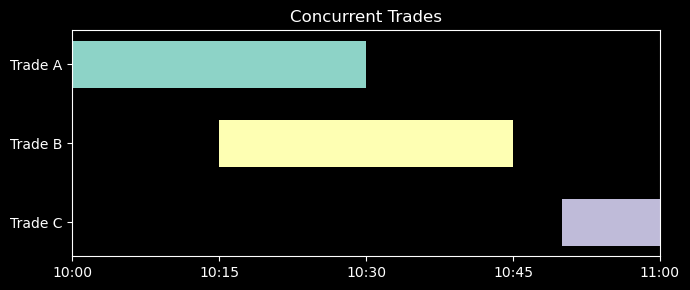

In [87]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_trade_timeline(trades, ticks=None, date_anchor="2025-01-01"):
    """
    trades: list of tuples (label, start_time, end_time) with HH:MM strings
            e.g., [("Trade A", "10:00", "10:30"), ...]
    ticks: optional list of HH:MM strings for exact x-axis ticks
           e.g., ["10:00", "10:15", "10:30", "10:45", "11:00"]
    date_anchor: anchor date to bind all times (YYYY-MM-DD)
    """
    fig, ax = plt.subplots(figsize=(7, 3), dpi=100)

    time_fmt = "%Y-%m-%d %H:%M"
    # Convert HH:MM to anchored datetimes
    def to_dt(t): return datetime.strptime(f"{date_anchor} {t}", time_fmt)

    # Plot bars in list order; we'll invert Y so first is top
    for i, (label, start, end) in enumerate(trades):
        start_dt, end_dt = to_dt(start), to_dt(end)
        ax.barh(
            y=i,
            width=end_dt - start_dt,
            left=start_dt,
            height=0.6,
            align="center",
            label=label
        )

    # Y-axis: labels and order (invert so first trade is at top)
    ax.set_yticks(range(len(trades)))
    ax.set_yticklabels([t[0] for t in trades])
    ax.invert_yaxis()  # ensures Trade A (index 0) is at the top

    # X-axis: exact ticks and formatting
    if ticks is None:
        # Default to min/max derived from trades, rounded to 15 min steps
        ticks = ["10:00", "10:15", "10:30", "10:45", "11:00"]
    tick_dts = [to_dt(t) for t in ticks]
    ax.set_xticks(tick_dts)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    # Limits to the tick range (optional but keeps labels clean)
    ax.set_xlim(tick_dts[0], tick_dts[-1])

    # Styling
    # ax.set_xlabel("Time")
    ax.set_title("Concurrent Trades")
    # Optional: legend on the right
    # ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
    fig.savefig("concurrent_trades.png")
    
    plt.tight_layout()
    plt.show()


# Example usage
trades = [
    ("Trade A", "10:00", "10:30"),
    ("Trade B", "10:15", "10:45"),
    ("Trade C", "10:50", "11:00"),
]
ticks = ["10:00", "10:15", "10:30", "10:45", "11:00"]

plot_trade_timeline(trades, ticks=ticks)


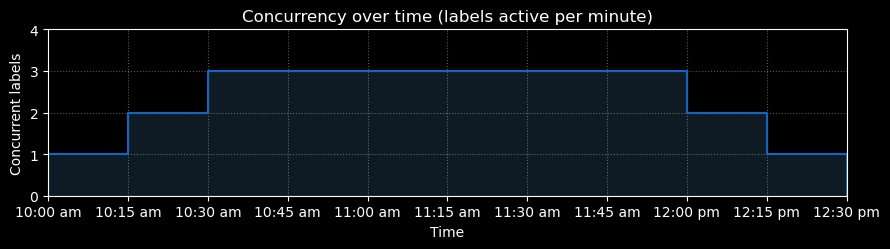

In [84]:
def plot_concurrency_track(signals, hold_minutes=45, date_anchor="2025-01-01", tick_every=15):
    parse = lambda s: datetime.strptime(f"{date_anchor} {s}", "%Y-%m-%d %I:%M %p")
    starts = [parse(s) for s in signals]
    ends = [s + timedelta(minutes=hold_minutes) for s in starts]
    t0, t1 = starts[0], ends[-1]

    # Build minute counts
    minute_counts = {}
    cur = t0.replace(second=0, microsecond=0)
    while cur <= t1:
        minute_counts[cur] = 0
        cur += timedelta(minutes=1)
    for s, e in zip(starts, ends):
        cur = s.replace(second=0, microsecond=0)
        while cur < e:
            minute_counts[cur] += 1
            cur += timedelta(minutes=1)

    # Downsample to ticks for a step plot
    tick_times = []
    tick_vals = []
    cur = t0.replace(second=0, microsecond=0)
    while cur <= t1:
        tick_times.append(cur)
        tick_vals.append(minute_counts.get(cur, 0))
        cur += timedelta(minutes=tick_every)

    fig, ax = plt.subplots(figsize=(9, 2.6))
    ax.step(tick_times, tick_vals, where="post", color="#1565c0")
    ax.fill_between(tick_times, tick_vals, step="post", alpha=0.15, color="#64b5f6")

    ax.set_xticks(tick_times)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%I:%M %p"))
    ax.set_xlim(tick_times[0], tick_times[-1])
    ax.set_ylim(0, max(tick_vals) + 1)

    ax.set_title("Concurrency over time (labels active per minute)")
    ax.set_ylabel("Concurrent labels")
    ax.set_xlabel("Time")
    ax.grid(axis="both", linestyle=":", alpha=0.35)
    plt.tight_layout()
    plt.show()

# Example
plot_concurrency_track(signals, hold_minutes=45)


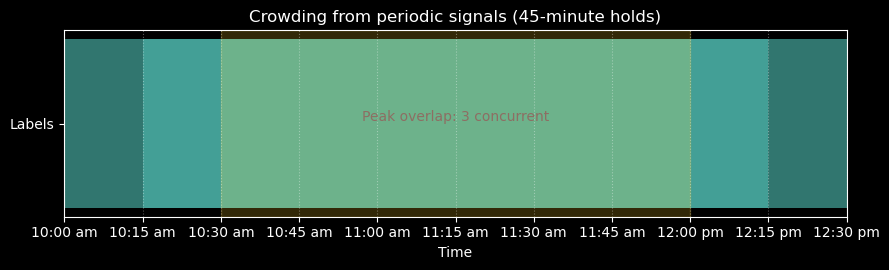

In [80]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from collections import Counter

def plot_crowding_fixed(
    signals,
    hold_minutes=45,
    date_anchor="2025-01-01",
    tick_every=15,
    compact=False,
    figsize=(9, 4)
):
    """
    signals: list of 'HH:MM AM/PM' strings
    hold_minutes: duration of each label
    compact: if True, draw a single-row broken timeline to avoid crowding
    """
    parse = lambda s: datetime.strptime(f"{date_anchor} {s}", "%Y-%m-%d %I:%M %p")
    starts = [parse(s) for s in signals]
    ends = [s + timedelta(minutes=hold_minutes) for s in starts]
    t0, t1 = starts[0], ends[-1]

    # Build x ticks at a fixed grid (e.g., 15 minutes)
    ticks_dt = []
    cur = t0.replace(second=0, microsecond=0)
    while cur <= t1:
        ticks_dt.append(cur)
        cur += timedelta(minutes=tick_every)

    # Minute-resolution concurrency
    # Count number of active trades for each minute
    minute_counts = Counter()
    for s, e in zip(starts, ends):
        cur = s.replace(second=0, microsecond=0)
        while cur < e:
            minute_counts[cur] += 1
            cur += timedelta(minutes=1)

    # Identify true peak band: longest contiguous interval at max concurrency
    if minute_counts:
        max_c = max(minute_counts.values())  # expected 4
        # collect contiguous minute intervals at max_c
        max_minutes = sorted([m for m, c in minute_counts.items() if c == max_c])
        # group into contiguous blocks
        bands = []
        block_start = max_minutes[0]
        for i in range(1, len(max_minutes)):
            if (max_minutes[i] - max_minutes[i-1]) != timedelta(minutes=1):
                bands.append((block_start, max_minutes[i-1]))
                block_start = max_minutes[i]
        bands.append((block_start, max_minutes[-1]))
        # choose the longest block as the peak band
        peak_start, peak_end = max(bands, key=lambda x: x[1] - x[0])
        # widen to tick boundaries for clear annotation
        # snap to nearest quarter-hour
        def snap_down(dt):
            m = (dt.minute // 15) * 15
            return dt.replace(minute=m, second=0, microsecond=0)
        def snap_up(dt):
            m = ((dt.minute + 14) // 15) * 15
            return dt.replace(minute=(m % 60), second=0, microsecond=0) + timedelta(hours=(dt.minute + 14) // 60)
        band_start = snap_down(peak_start)
        band_end = snap_up(peak_end + timedelta(minutes=1))
    else:
        max_c, band_start, band_end = 0, None, None

    fig, ax = plt.subplots(figsize=figsize)

    if compact:
        # Single-row broken timeline to avoid vertical crowding
        # Use broken_barh with segments for each trade
        spans = [(s, (e - s)) for s, e in zip(starts, ends)]
        # matplotlib's broken_barh expects numeric; use dates with barh instead
        # So emulate broken look by drawing semi-transparent bars all on y=0
        for s, e in zip(starts, ends):
            ax.barh(
                y=0, left=s, width=e - s, height=0.8,
                color="#4db6ac", alpha=0.65, edgecolor="none"
            )
        ax.set_yticks([0])
        ax.set_yticklabels(["Labels"])
    else:
        # Full timeline with one row per signal
        for i, (s, e) in enumerate(zip(starts, ends)):
            ax.barh(
                y=i, left=s, width=e - s, height=0.6,
                color="#4db6ac", edgecolor="none"
            )
        ax.set_yticks(range(len(signals)))
        ax.set_yticklabels(signals)
        ax.invert_yaxis()

    # Exact peak band overlay
    if band_start and band_end and max_c > 0:
        ax.axvspan(band_start, band_end, color="#ffca28", alpha=0.2)
        ax.text(
            band_start + (band_end - band_start)/2,
            (0 if compact else -0.6),
            f"Peak overlap: {max_c} concurrent",
            ha="center", va="bottom", fontsize=10, color="#8d6e63"
        )

    ax.set_xticks(ticks_dt)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%I:%M %p"))
    ax.set_xlim(ticks_dt[0], ticks_dt[-1])

    ax.set_title("Crowding from periodic signals (45-minute holds)")
    ax.set_xlabel("Time")
    ax.grid(axis="x", linestyle=":", alpha=0.35)
    plt.tight_layout()
    plt.show()


# Example
signals = [
    "10:00 AM", "10:15 AM", "10:30 AM", "10:45 AM",
    "11:00 AM", "11:15 AM", "11:30 AM", "11:45 AM",
]
plot_crowding_fixed(signals, hold_minutes=45, compact=True, figsize=(9, 2.8))
